In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')


In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [5]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)
meta_df.sample_number = pd.to_numeric(meta_df.sample_number)

In [6]:
import json
with open(os.path.join('DNA','dnaseq', 'qualimap_multiqc_data','multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [7]:

qualimap_json.keys()

dict_keys(['report_data_sources', 'report_general_stats_data', 'report_general_stats_headers', 'report_multiqc_command', 'report_plot_data', 'report_saved_raw_data', 'config_analysis_dir_abs', 'config_analysis_dir', 'config_creation_date', 'config_git_hash', 'config_intro_text', 'config_report_comment', 'config_report_header_info', 'config_script_path', 'config_short_version', 'config_subtitle', 'config_title', 'config_version'])

In [8]:
qmap_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [9]:
len(qualimap_json['report_general_stats_data'])

1

In [10]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
bamqc_df = pd.DataFrame([_item_to_dict(k,v) for k,v in qualimap_json['report_general_stats_data'][0].items()])

In [11]:
bamqc_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     550761.0      134228.0           24.371370                0.44   
1      79690.0        9854.0           12.365416                3.72   
2     268388.0       54226.0           20.204331                0.18   
3     221198.0        1103.0            0.498648               11.42   
4     261903.0      251977.0           96.210047                0.28   

   mean_coverage             Key  median_coverage  median_insert_size  avg_gc  \
0         4.8599         12_1A3               NaN                 NaN     NaN   
1         0.3646          21_DE               NaN                 NaN     NaN   
2         4.9590     18_MIT0604               NaN                 NaN     NaN   
3         0.0442  17_Maricaulis               NaN                 NaN     NaN   
4         9.0282         06_1A3               NaN                 NaN     NaN   

   1_x_pc  5_x_pc  10_x_pc  30_x_pc  50_x_pc  
0     NaN     NaN      NaN      NaN      NaN  
1     NaN     NaN      NaN      NaN      NaN  
2     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN      NaN      NaN      NaN  
4     NaN     NaN      NaN      NaN      NaN

In [12]:
bamqc_df = bamqc_df.pivot_table(index='Key').reset_index()
bamqc_df = bamqc_df.loc[~bamqc_df.Key.isin(['08_1A3', '08_MIT9313'])]
bamqc_df[['sample_number', 'species']] = bamqc_df.Key.str.split('_', expand=True)
bamqc_df['sample_number'] = pd.to_numeric(bamqc_df['sample_number'])
bamqc_df = bamqc_df.loc[bamqc_df.sample_number != 8]

bamqc_df.head()


Key    10_x_pc     1_x_pc    30_x_pc    50_x_pc     5_x_pc  \
0         01_1A3   99.665126  99.986713  44.556351   2.066889  99.956183   
1          02_DE   99.530857  99.948538  42.842870   1.027107  99.871411   
2     03_MIT9313   99.511546  99.995106  49.137470   2.178381  99.926126   
3     04_MIT0604   99.686022  99.756750  73.074687  10.393352  99.751076   
4  04_Maricaulis    0.000000   0.853247   0.000000   0.000000   0.004720   

      avg_gc  general_error_rate  mapped_reads  mean_coverage  \
0  45.442369                0.30      818317.0        29.0857   
1  45.545246                0.52      741707.0        28.4919   
2  51.545547                0.21      544213.0        29.7018   
3  32.475995                0.19      366615.0        36.2127   
4  60.340426               11.37         404.0         0.0180   

   median_coverage  median_insert_size  percentage_aligned  total_reads  \
0             28.0               153.0           99.578719     821779.0   
1             28.0               156.0           98.530492     752769.0   
2             29.0               114.0           98.872316     550420.0   
3             36.0               160.0           68.248963     537173.0   
4              0.0               148.0            0.246791     163701.0   

   sample_number      species  
0              1         1A3   
1              2          DE   
2              3     MIT9313   
3              4     MIT0604   
4              4  Maricaulis

In [13]:
bamqc_df = pd.merge(bamqc_df, meta_df, on='sample_number', how='left')

In [14]:
bamqc_df.columns

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       'median_coverage', 'median_insert_size', 'percentage_aligned',
       'total_reads', 'sample_number', 'species', 'sample', 'PRO', 'ALT',
       'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

In [15]:
value_cols = ['sample', 'PRO', 'ALT',
       'exp', '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
       
         'percentage_aligned','median_coverage','mean_coverage','median_insert_size',
        'general_error_rate', 'mapped_reads', 'total_reads'
             ]
        
pct_cols = [ '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
         'percentage_aligned']
with pd.ExcelWriter('bamqc_stats.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for i in bamqc_df.species.unique():
        bamqc_pdf = bamqc_df.loc[bamqc_df.species.isin([i])].pivot(index='sample_number', columns='species', 
                               values=value_cols)
        bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
        bamqc_pdf.rename(columns=qmap_titles, inplace=True)
        sheetname = f'{i} bamqc'
        bamqc_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('F:J', None, format2)
        worksheet.set_column('L:L', None, format1)
        
        
        worksheet.conditional_format(f'F1:H{bamqc_df.shape[0]+2}', {'type': 'data_bar'})
        worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})
    



In [16]:
import json
with open(os.path.join('DNA','dnaseq_trimmed', 'multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [17]:
trimmed_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [18]:
len(qualimap_json['report_general_stats_data'])

4

In [19]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
trimmed_df = pd.DataFrame([
    _item_to_dict(k,v) 
    for d in qualimap_json['report_general_stats_data']
    for k,v in d.items()
])

In [20]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  forward_only_surviving_pct  reverse_only_surviving  \
0   0.159721  ...                         NaN                     NaN   
1   0.117342  ...                         NaN                     NaN   
2   0.413449  ...                         NaN                     NaN   
3   0.375300  ...                         NaN                     NaN   
4  99.705684  ...                         NaN                     NaN   

   reverse_only_surviving_pct dropped dropped_pct  percent_gc  \
0                         NaN     NaN         NaN         NaN   
1                         NaN     NaN         NaN         NaN   
2                         NaN     NaN         NaN         NaN   
3                         NaN     NaN         NaN         NaN   
4                         NaN     NaN         NaN         NaN   

   avg_sequence_length  total_sequences  percent_duplicates  percent_fails  
0                  NaN              NaN                 NaN            NaN  
1                  NaN              NaN                 NaN            NaN  
2                  NaN              NaN                 NaN            NaN  
3                  NaN              NaN                 NaN            NaN  
4                  NaN              NaN                 NaN            NaN  

[5 rows x 108 columns]

In [21]:
trimmed_df['Key'].unique()



array(['snippy_19_DE_all', 'snippy_19_DE_filtered', 'snippy_19_1A3_all',
       'snippy_19_MIT9313_all', 'snippy_19_MIT0604_all',
       'snippy_19_MIT0604_filtered', 'snippy_10_MIT9313_all',
       'snippy_10_MIT0604_filtered', 'snippy_10_MIT0604_all',
       'snippy_10_1A3_all', 'snippy_10_DE_all', 'snippy_10_1A3_filtered',
       'snippy_17_DE_filtered', 'snippy_17_DE_all',
       'snippy_17_MIT9313_all', 'snippy_17_MIT0604_filtered',
       'snippy_17_MIT0604_all', 'snippy_17_1A3_all',
       'snippy_13_MIT0604_all', 'snippy_13_MIT9313_all',
       'snippy_13_1A3_filtered', 'snippy_13_DE_all', 'snippy_13_1A3_all',
       'snippy_13_MIT0604_filtered', 'snippy_11_MIT0604_all',
       'snippy_11_1A3_all', 'snippy_11_MIT0604_filtered',
       'snippy_11_1A3_filtered', 'snippy_11_DE_all',
       'snippy_11_MIT9313_all', 'snippy_20_DE_filtered',
       'snippy_20_MIT0604_all', 'snippy_20_1A3_all',
       'snippy_20_MIT0604_filtered', 'snippy_20_DE_all',
       'snippy_20_MIT9313_all', 's

In [22]:
def _key_to_sample_species(x):
    mode = None
    if x.startswith('200219Seg_D20-16'):
        idx = x.replace('200219Seg_D20-', '').replace('_1_sequence','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'fastqc'
        species = None
    elif x.startswith('trim_200219Seg_D20'):
        idx = x.replace('trim_200219Seg_D20-', '').replace('_1_sequence_P','').replace('_2_sequence_P','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'trimmomatic'
        species = None
    elif x.startswith('freebayes_'):
        sample_number = None
        command = 'freebayes'
        species = x.replace('freebayes_', '')
    elif x.startswith('snippy_'):
        _, idx, species, mode = x.split('_')
        sample_number = pd.to_numeric(idx) 
        command = 'bamqc'
    return pd.Series({
        'species' : species,
         'mode' :mode,
        'sample_number' :sample_number,
        'command' : command,
    })

trimmed_df = pd.concat([trimmed_df, trimmed_df['Key'].apply(_key_to_sample_species)], axis=1)


In [23]:
trimmed_df = trimmed_df.loc[trimmed_df['sample_number'] != 8]

In [24]:
trimmed_df = pd.merge(trimmed_df, meta_df, on='sample_number', how='left')

In [25]:
trimmed_df['pair'] = trimmed_df['PRO'] + ',' + trimmed_df['ALT']

In [26]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp', 'days',
       'ng/ul', 'final volume', 'pair'],
      dtype='object', length=120)

In [27]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  sample_number  command  sample      PRO ALT  exp  days  \
0   0.159721  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
1   0.117342  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
2   0.413449  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
3   0.375300  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
4  99.705684  ...           19.0    bamqc     10B  MIT0604  DE    6   440   

   ng/ul  final volume        pair  
0   6.25           100  MIT0604,DE  
1   6.25           100  MIT0604,DE  
2   6.25           100  MIT0604,DE  
3   6.25           100  MIT0604,DE  
4   6.25           100  MIT0604,DE  

[5 rows x 120 columns]

In [28]:
bamqc_df.head()

Key    10_x_pc     1_x_pc    30_x_pc    50_x_pc     5_x_pc  \
0         01_1A3   99.665126  99.986713  44.556351   2.066889  99.956183   
1          02_DE   99.530857  99.948538  42.842870   1.027107  99.871411   
2     03_MIT9313   99.511546  99.995106  49.137470   2.178381  99.926126   
3     04_MIT0604   99.686022  99.756750  73.074687  10.393352  99.751076   
4  04_Maricaulis    0.000000   0.853247   0.000000   0.000000   0.004720   

      avg_gc  general_error_rate  mapped_reads  mean_coverage  ...  \
0  45.442369                0.30      818317.0        29.0857  ...   
1  45.545246                0.52      741707.0        28.4919  ...   
2  51.545547                0.21      544213.0        29.7018  ...   
3  32.475995                0.19      366615.0        36.2127  ...   
4  60.340426               11.37         404.0         0.0180  ...   

   total_reads  sample_number      species  sample      PRO     ALT exp days  \
0     821779.0              1         1A3   Axenic   Axenic     1A3   0    0   
1     752769.0              2          DE   Axenic   Axenic      DE   0    0   
2     550420.0              3     MIT9313   Axenic  MIT9313  Axenic   0    0   
3     537173.0              4     MIT0604   Axenic  MIT0604  Axenic   0    0   
4     163701.0              4  Maricaulis   Axenic  MIT0604  Axenic   0    0   

  ng/ul final volume  
0    30          100  
1    10          100  
2   0.6          100  
3     6          100  
4     6          100  

[5 rows x 23 columns]

In [29]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp', 'days',
       'ng/ul', 'final volume', 'pair'],
      dtype='object', length=120)

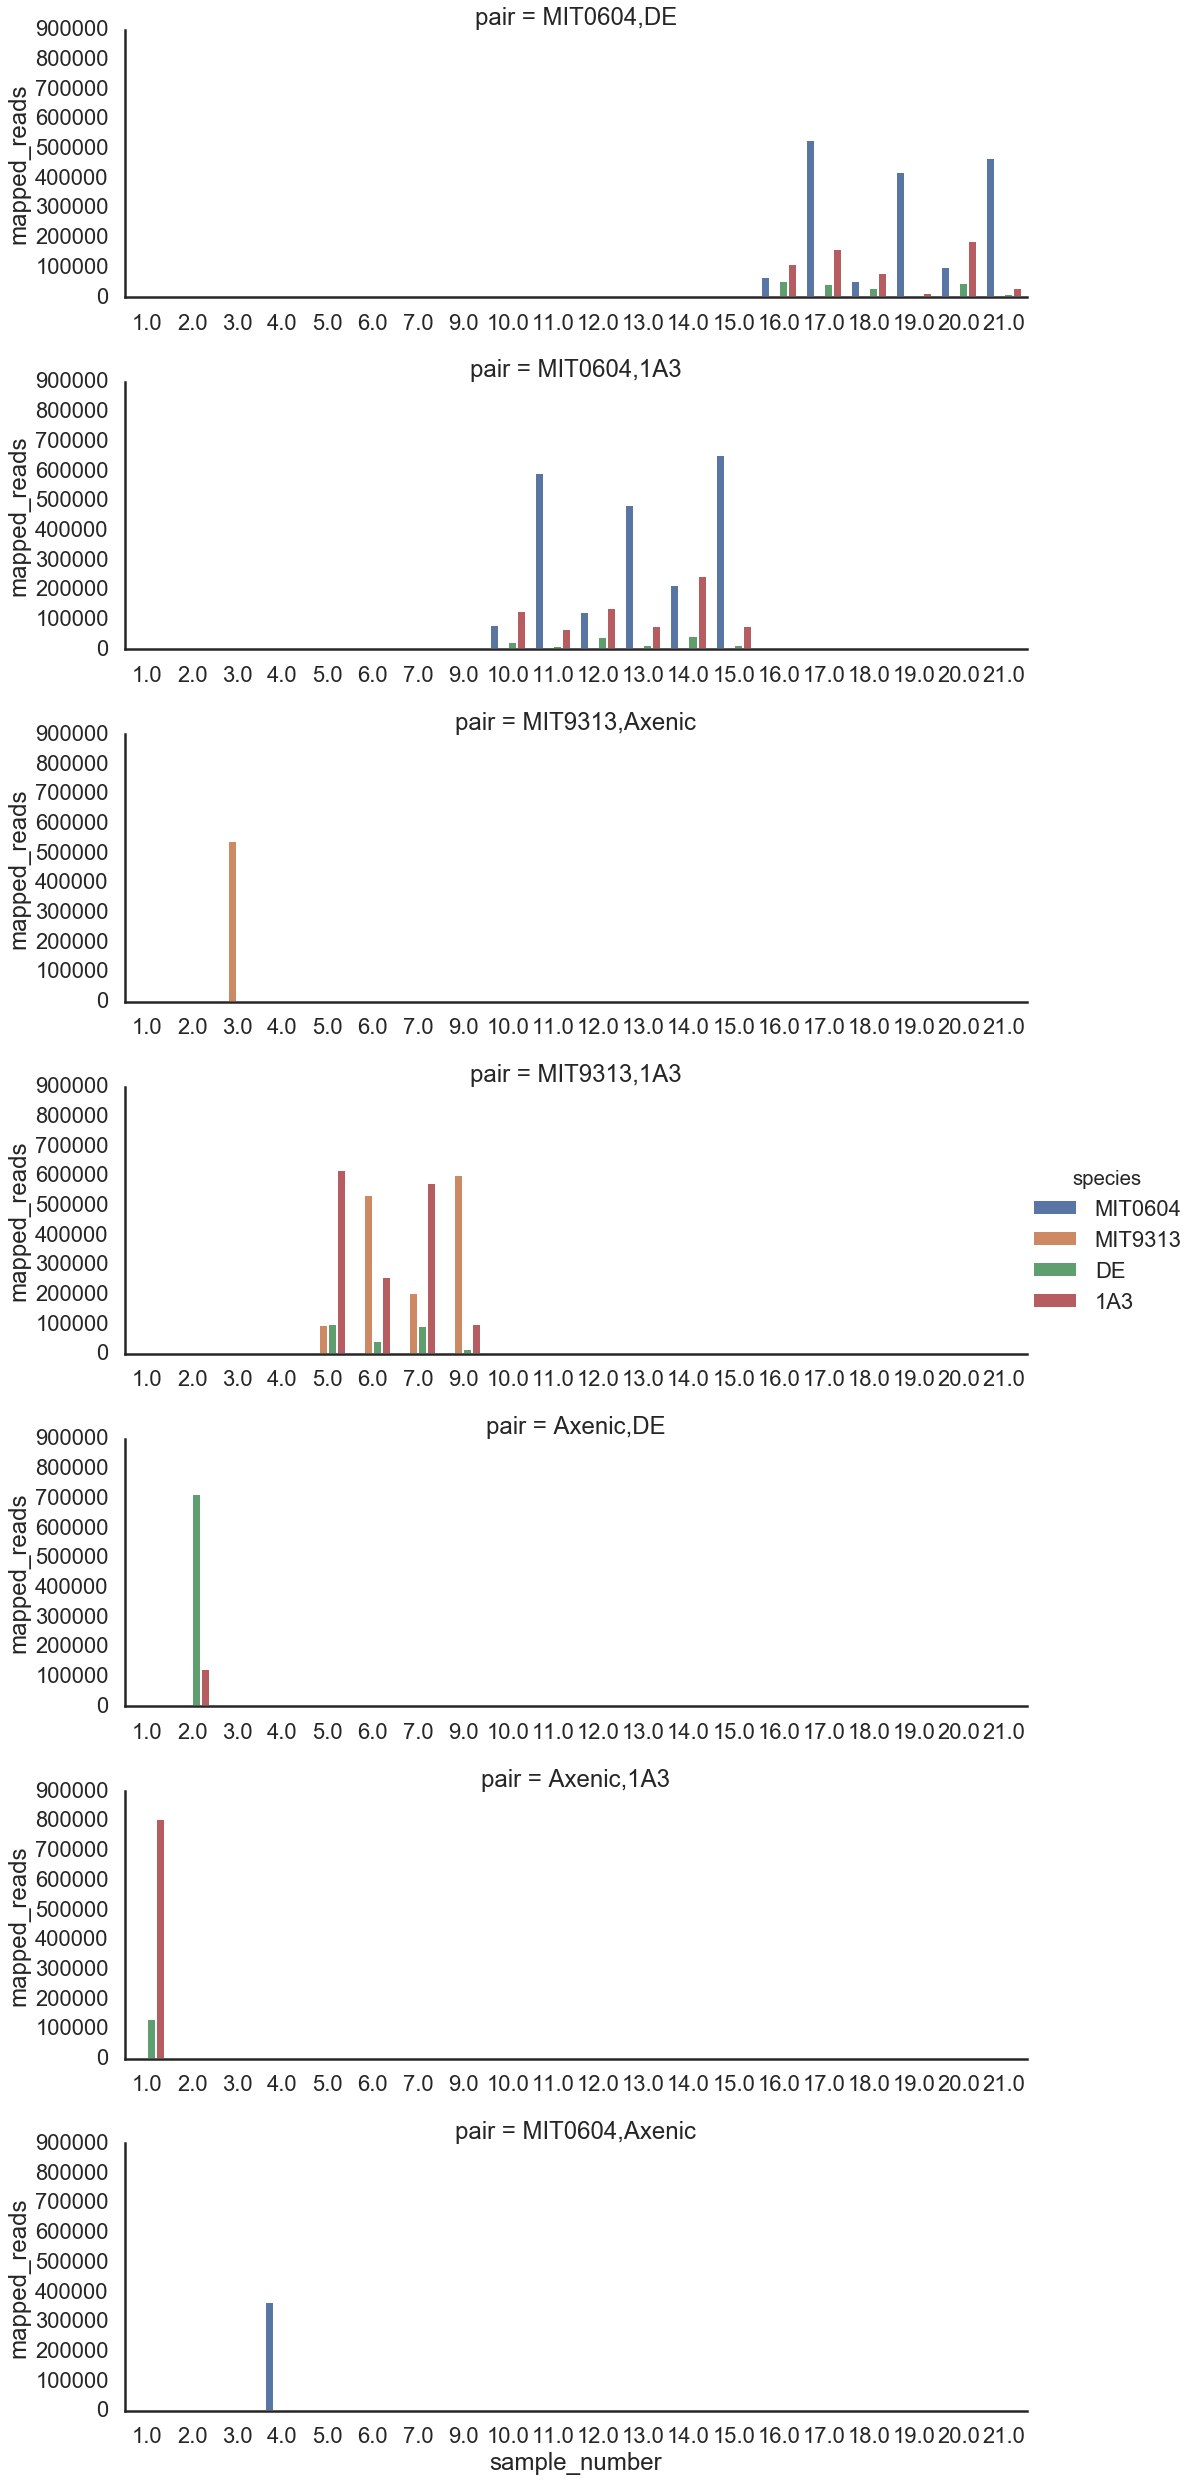

In [30]:
#for i in trimmed_df['pair'].dropna().unique():
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
 #                                   & (trimmed_df['pair'] == i)
                                   ],
                x='sample_number', y='mapped_reads', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
#plt.title(i)

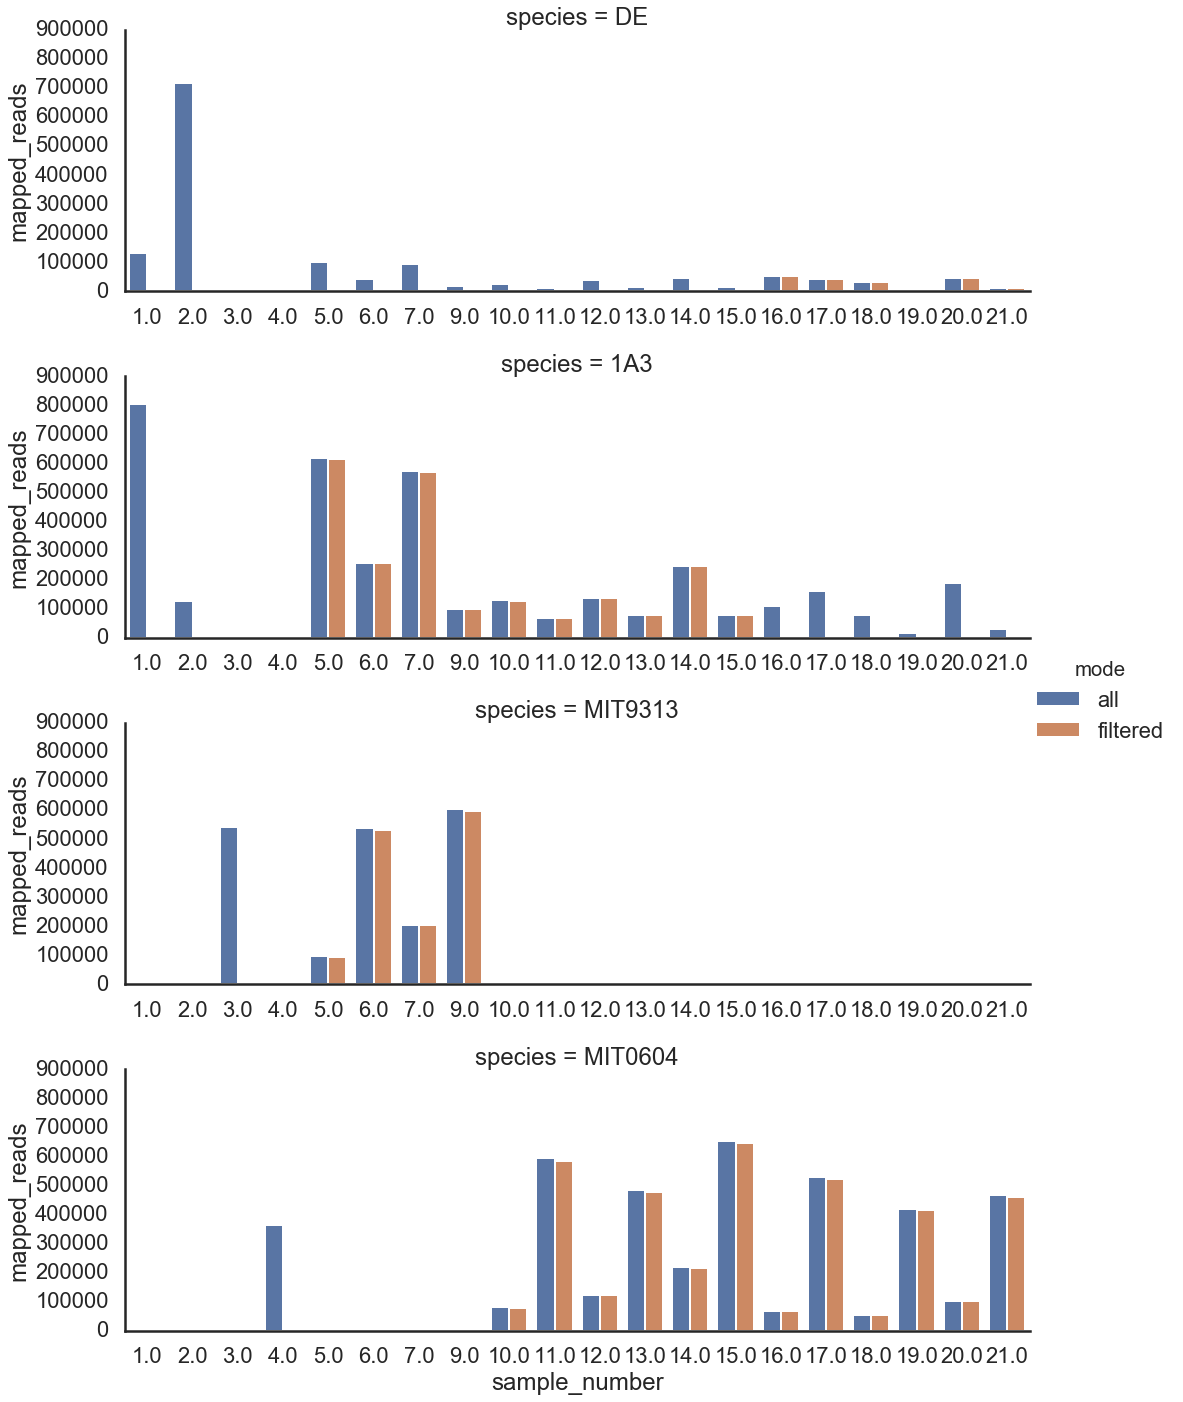

In [31]:
# pd.options.display.float_format = '{:d}'.format
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc')],
            x='sample_number', y='mapped_reads', 
           row='species', hue='mode', sharex=False,
           aspect=3, kind='bar')

In [32]:
 trimmed_df.sample_number.dtypes

dtype('float64')

In [33]:
bamqc_df['trim'] = 'adapter'
trimmed_df['trim'] = 'Q>20'
pd.options.display.float_format = '{:.0f}'.format

merged_stat_df = pd.concat([
    bamqc_df.loc[~bamqc_df.species.isin(['Maricaulis '])], 
    trimmed_df.loc[
        (trimmed_df['command'] == 'bamqc') & 
        ((trimmed_df['mode'] == 'filtered') |
         ((trimmed_df['sample_number'] < 5)  & 
          (trimmed_df.PRO == trimmed_df.species) | (trimmed_df.ALT == trimmed_df.species)))
                                            ] 
                                            ],
        )

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [34]:
merged_stat_df.species = merged_stat_df.species.str.strip()

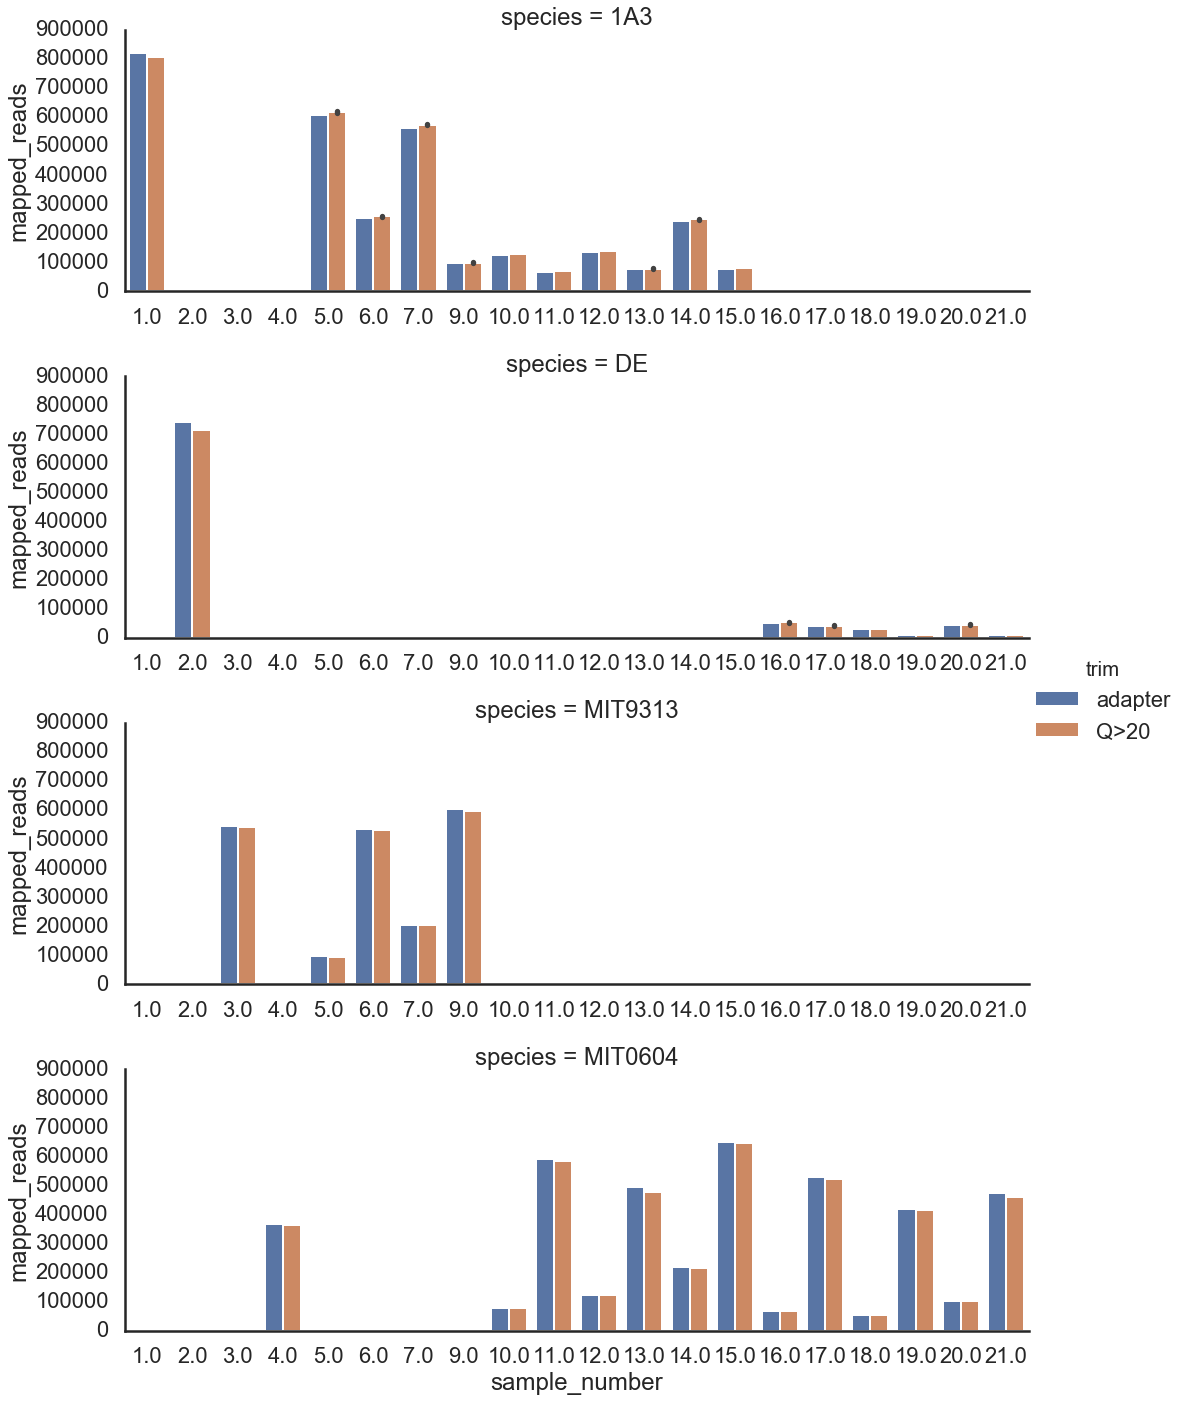

In [35]:
sns.catplot(data=merged_stat_df,
            x='sample_number', y='mapped_reads', 
           row='species', hue='trim', sharex=False,
           aspect=3, kind='bar')

Text(0.5, 1, 'mapped reads')

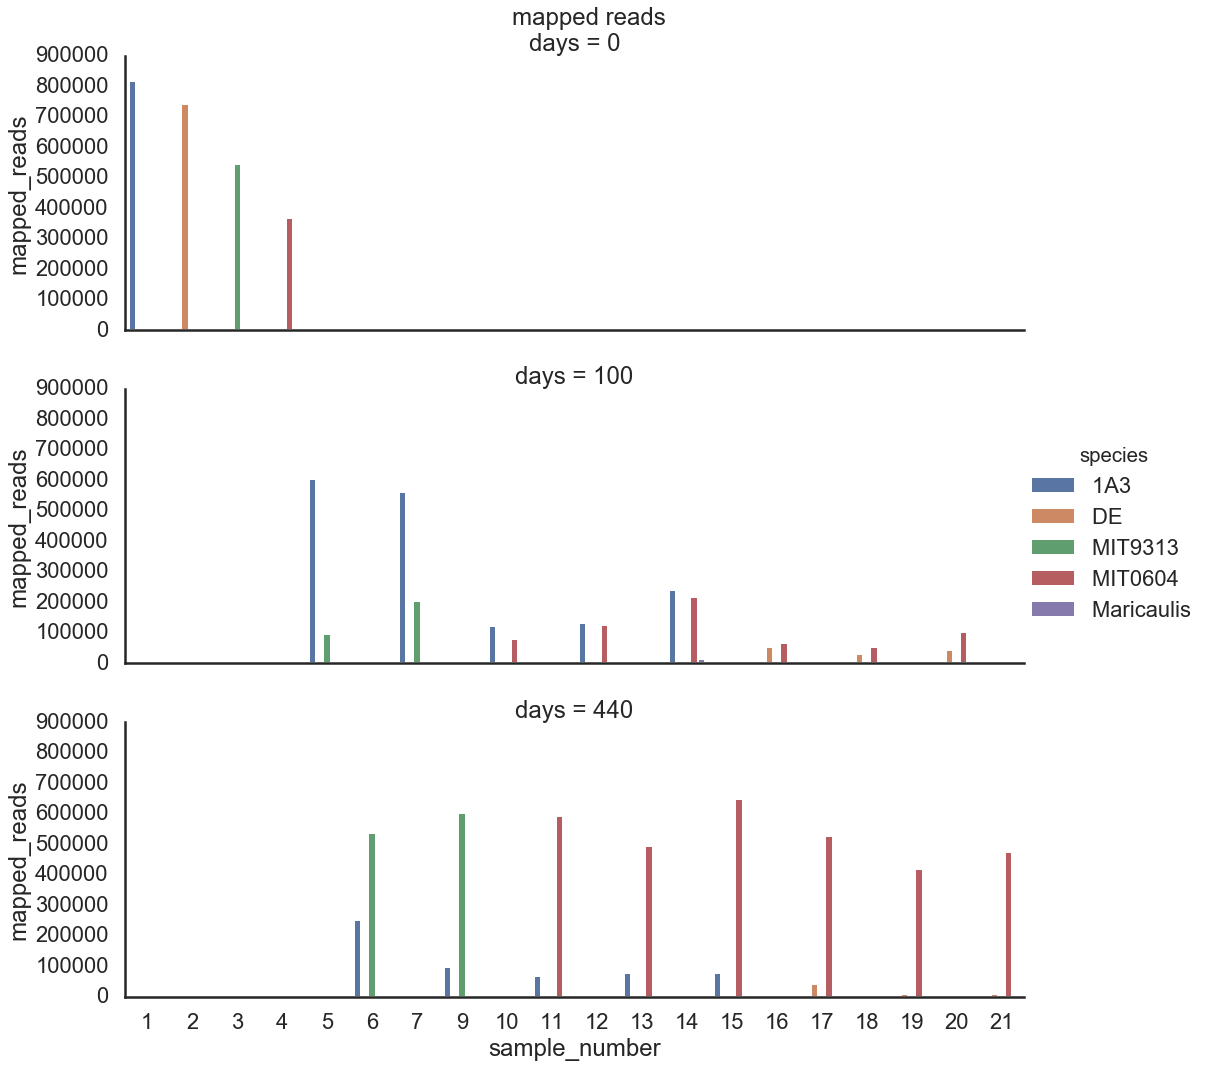

In [36]:
sns.set_style('white')
sns.set_context('poster')
sns.catplot(data=bamqc_df, x='sample_number', y='mapped_reads',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('mapped reads', y=1)

Text(0.5, 1, '% cov > 10x')

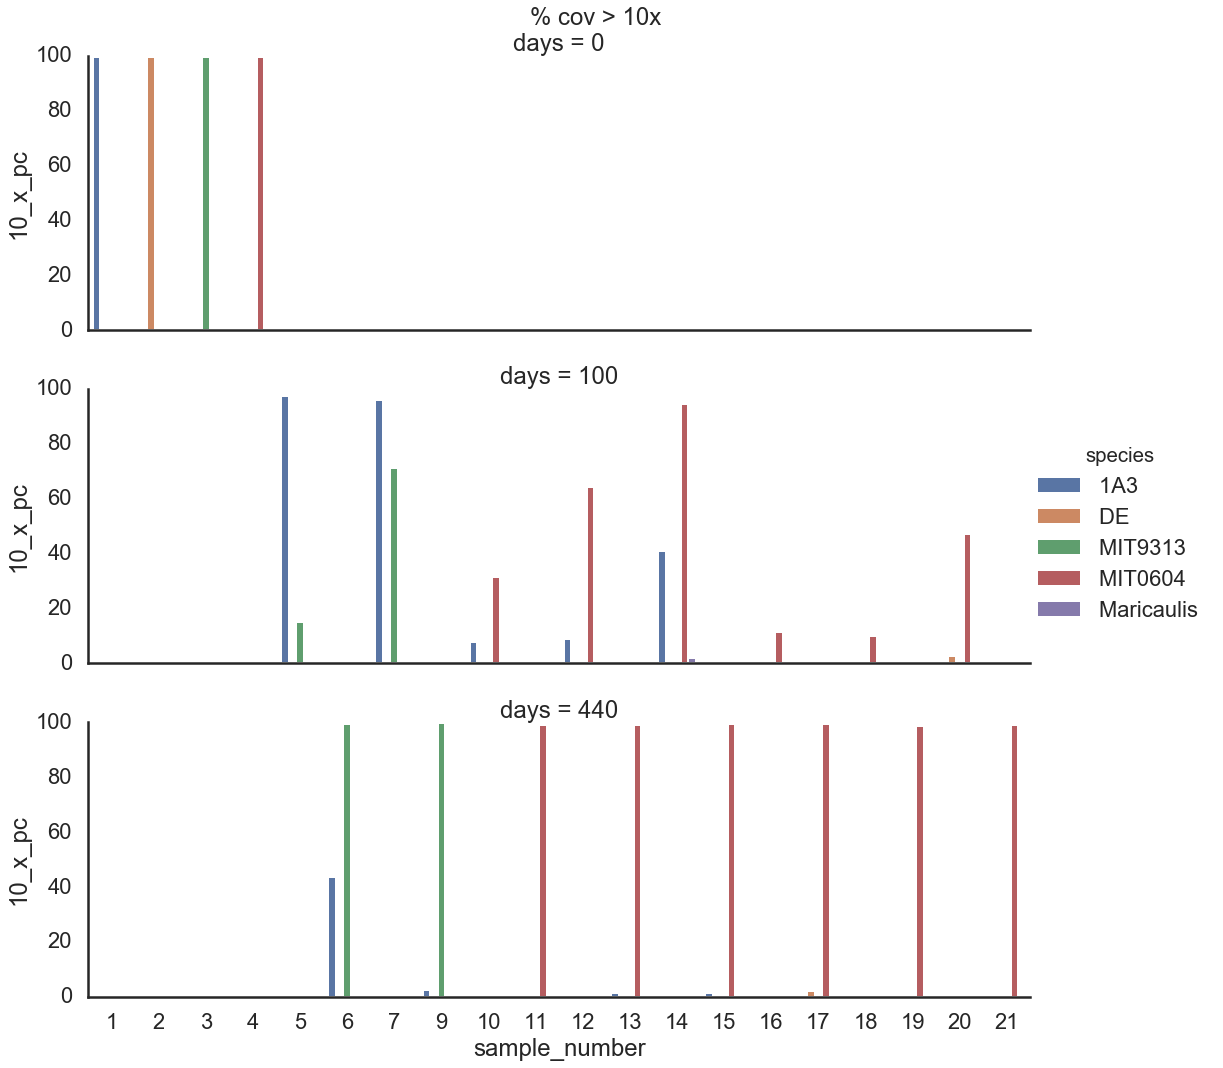

In [37]:
sns.set_style('white')
#sns.set_context('paper')
sns.catplot(data=bamqc_df, x='sample_number', y='10_x_pc',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('% cov > 10x', y=1)

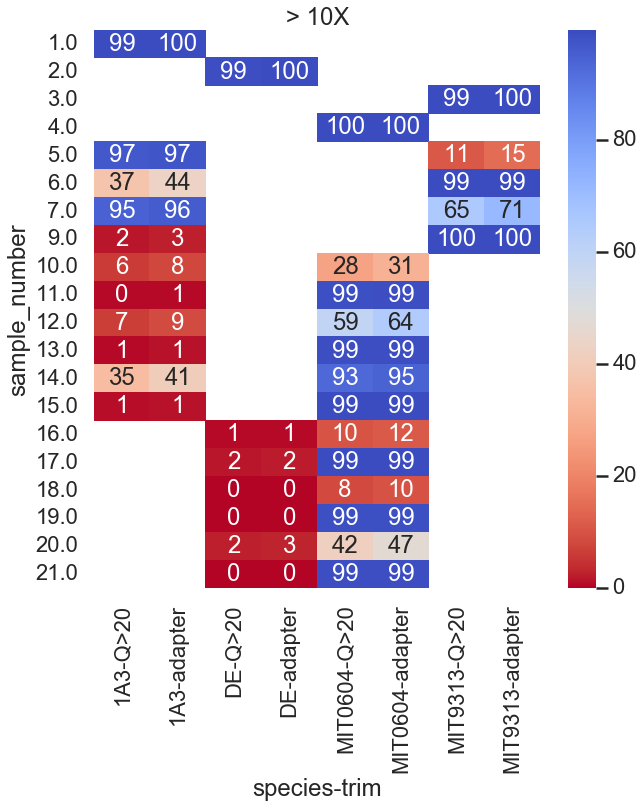

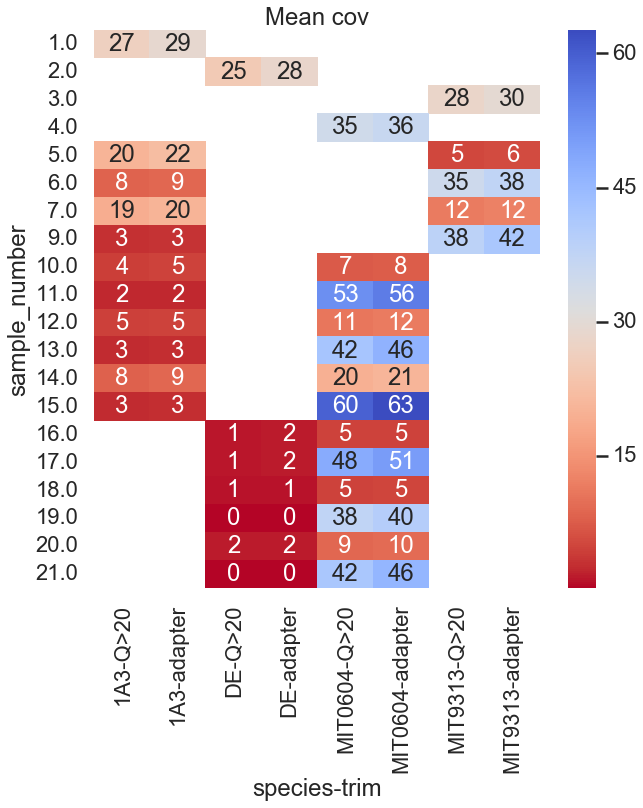

In [38]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.pivot_table(index='sample_number', columns=['species', 'trim'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

In [39]:
#from glob import glob
#data_dpath = os.path.join('DNA','freebayes')
data_dpath = os.path.join('DNA','dnaseq_trimmed')
# ##INFO=<ID=ANN,Number=.,Type=String,
#Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | 
#            Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | 
#              Rank | HGVS.c | HGVS.p | 
# cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
def _parse_csv(t):
    ANN_columns = [
        'Allele', 'Annotation',  'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
        'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p', 'cDNA.pos',  'CDS.pos', 
        'AA.pos', 'Distance', 'ERRORS'
    ]
    #idx = 160000+i
    #dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    fpath = os.path.join(data_dpath, #f'freebayes_{t}',
                         f'freebayes_{t}.tab')
    df =  pd.read_csv(fpath, sep='\t') 
    df['species'] = t
    df.ANN = df.ANN.str.split(',')
    df = df.apply( pd.Series.explode )


    df[ANN_columns] = df['ANN'].str.split('|', expand=True)
    df = df.drop('ANN', axis=1)
    return df

df_MIT9313 = _parse_csv('MIT9313') 
df_MIT0604 = _parse_csv('MIT0604') 
df_DE = _parse_csv('DE') 
df_1A3 = _parse_csv('1A3') 


In [40]:
def parse_freebayes(genome):
    df_s =  _parse_csv(genome) 
    id_vars=['CHROM', 'POS', 'TYPE', 'REF', 'ALT', 
       'species', 'Allele', 'Annotation', 'Impact', 'Gene_Name', 'Gene_ID',
       'Feature_Type', 'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c',
       'HGVS.p', 'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS']


    d = df_s.melt(id_vars=id_vars)
    d['variable'] = d['variable'].str.replace('D20-1600', '')
    d[['sample_number', 'variable']] = d['variable'].str.split('.',expand=True)
    d['sample_number'] = pd.to_numeric(d['sample_number'])

    pdf = d.pivot_table(index=(id_vars+['sample_number']), columns=['variable'], aggfunc='first', #values='value',
                   ).droplevel(level=0, axis='columns').reset_index() 
    
    pdf['good_call'] = (pdf.DP > 10) & (pdf.GQ > 20)
    mask = (~pdf.AO.astype(str).str.contains(',', na=False, regex=False) & 
            ~pdf.DP.astype(str).str.contains(',', na=False, regex=False) &
            (pdf['DP'] != 0) & pdf['good_call'])
    try: 
        pdf.loc[mask, 'fraction_Alt'] = pdf.loc[mask, 'AO'] / pdf.loc[mask, 'DP']
    except Exception:
        pdf['fraction_Alt'] = ''

    
    pdf['culture'] = 'Co_Culture'
    pdf.loc[pdf['sample_number']<=4, 'culture'] = 'Axenic'
    
    df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
    #df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
    #                          sheet_name='9313+1A3')
    genome_cols = ['gene_id', 'pmt_id', 'type',  'strand', 
       'product', 'protein_id']
    mpdf = pd.merge(pdf, 
                    df_genome[genome_cols], left_on='Gene_Name', right_on='gene_id', 
                    how='left'
                   )
    #mpdf[['PMTID1', 'PMTID2']] = mpdf.pmt_id.str.split(',', expand=True)
    mpdf = pd.merge(mpdf, meta_df, on='sample_number', how='left')
    mpdf['good_call'] = (mpdf.DP > 10) & (mpdf.GQ > 20)
    mpdf.loc[mpdf.good_call & (mpdf.ALT_x == mpdf.GT), 'call'] = 1
    mpdf.loc[mpdf.good_call & (mpdf.REF == mpdf.GT), 'call'] = 0
    mpdf.loc[mpdf.good_call & (mpdf.REF != mpdf.GT) & (mpdf.ALT_x != mpdf.GT), 'call'] = -1
    return mpdf

In [41]:
genome='MIT9313'
df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
df_genome.columns

C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Index(['contig_id', 'gene_id', 'pmt_id', 'type', 'location', 'strand', 'start',
       'stop', 'left', 'right', 'function', 'genome', 'old_locus_tag',
       'product', 'db_xref', 'protein_id', 'figfam', 'nucleotide_sequence',
       'aa_sequence'],
      dtype='object')

In [42]:
dfs = dict()
for s in ['MIT0604', 'MIT9313', 'DE', '1A3']:
    dfs[s] = parse_freebayes(s)


In [43]:
df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
                              sheet_name='9313+1A3')
df_DE_MIT9313.rename(columns={'log 2 fold change coculture/axenic' : 'log Fold Change'}, inplace=True)
de_cols = ['Synonym', 'q Value ', 'log Fold Change']
dfs['MIT9313'][['PMTID1', 'PMTID2']] = dfs['MIT9313'].pmt_id.str.split(',', expand=True)

dfs['MIT9313'] = pd.merge(dfs['MIT9313'], 
                df_DE_MIT9313[de_cols], left_on='PMTID1', right_on='Synonym', 
                how='left'
               )


In [44]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 'pmt_id', 'type', 'strand', 'product']
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', 'DP', 'AO', 'RO','GQ','GT',  ]
species= 'MIT9313'


condition_format_cols = {
    'MIT9313' : ['T7:X10000', 'Y7:AC10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'Y:AC',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = dfs[species].loc[dfs[species]['type'].isin(['CDS'])].fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('R:S', None, format1)
        worksheet.set_column('Q:Q', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [45]:
dfs[species].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call'],
      dtype='object')

Text(0.5, 1, 'MIT9313 calls')

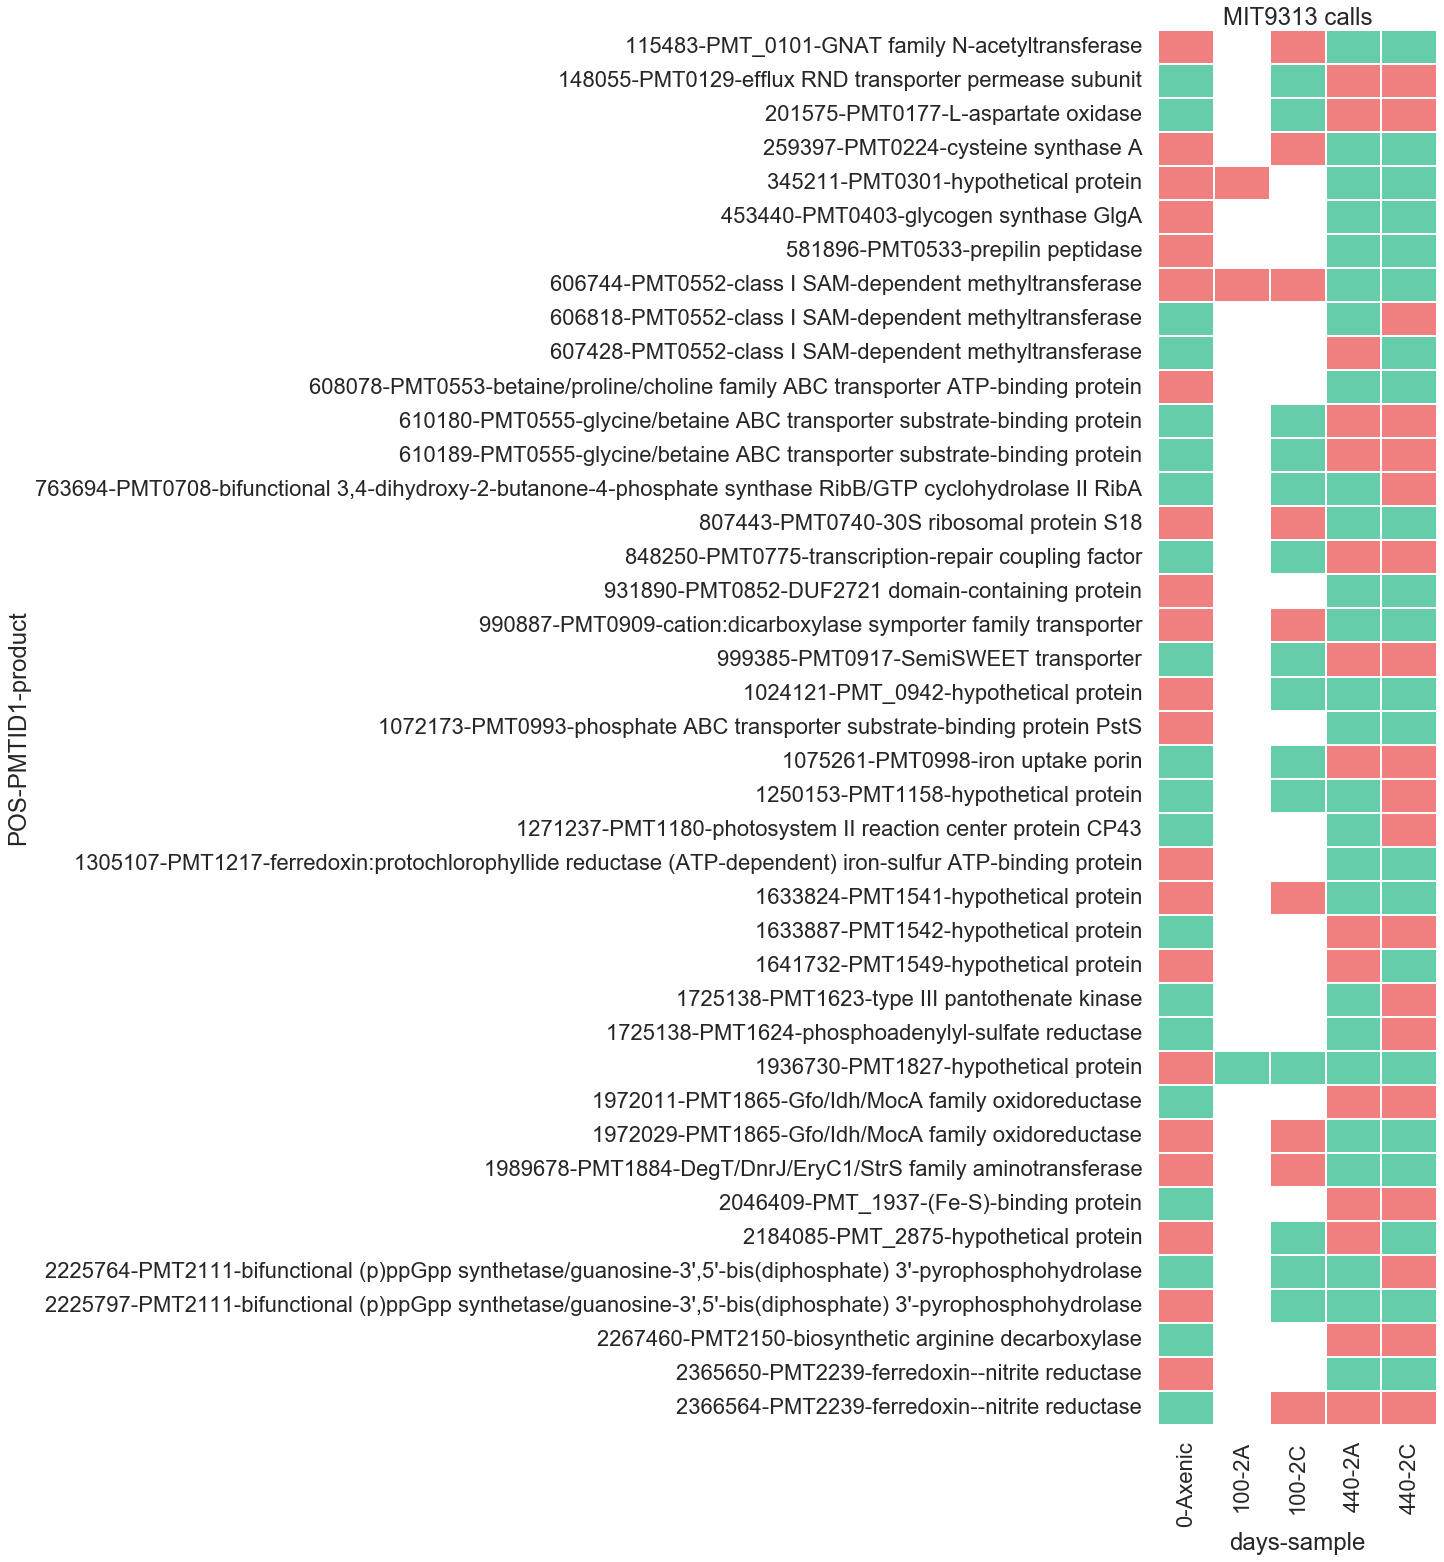

In [46]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [47]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1]
good_call_gene_ids = pvdf.loc[pvdf.std(axis=1) > 1e-1, 'gene_id']
dfs[species]['diff_snp'] = False
dfs[species].loc[dfs[species]['gene_id'].isin(good_call_gene_ids), 'diff_snp'] = True



In [48]:
dfs[species].head()

CHROM    POS   TYPE REF ALT_x  species Allele          Annotation  \
0  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
1  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
2  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
3  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
4  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   

  Impact      Gene_Name  ...   days  ng/ul final volume call   PMTID1  \
0   HIGH  AKG35_RS00340  ...      0      1          100    1  PMT0064   
1   HIGH  AKG35_RS00340  ...    100      1          100  nan  PMT0064   
2   HIGH  AKG35_RS00340  ...    440      1          100    1  PMT0064   
3   HIGH  AKG35_RS00340  ...    100      2          100  nan  PMT0064   
4   HIGH  AKG35_RS00340  ...  empty  empty        empty  nan  PMT0064   

     PMTID2  Synonym q Value  log Fold Change diff_snp  
0  PMT_0064  PMT0064        1              -1    False  
1  PMT_0064  PMT0064        1              -1    False  
2  PMT_0064  PMT0064        1              -1    False  
3  PMT_0064  PMT0064        1              -1    False  
4  PMT_0064  PMT0064        1              -1    False  

[5 rows x 51 columns]

Text(0.5, 1, 'MIT0604 calls')

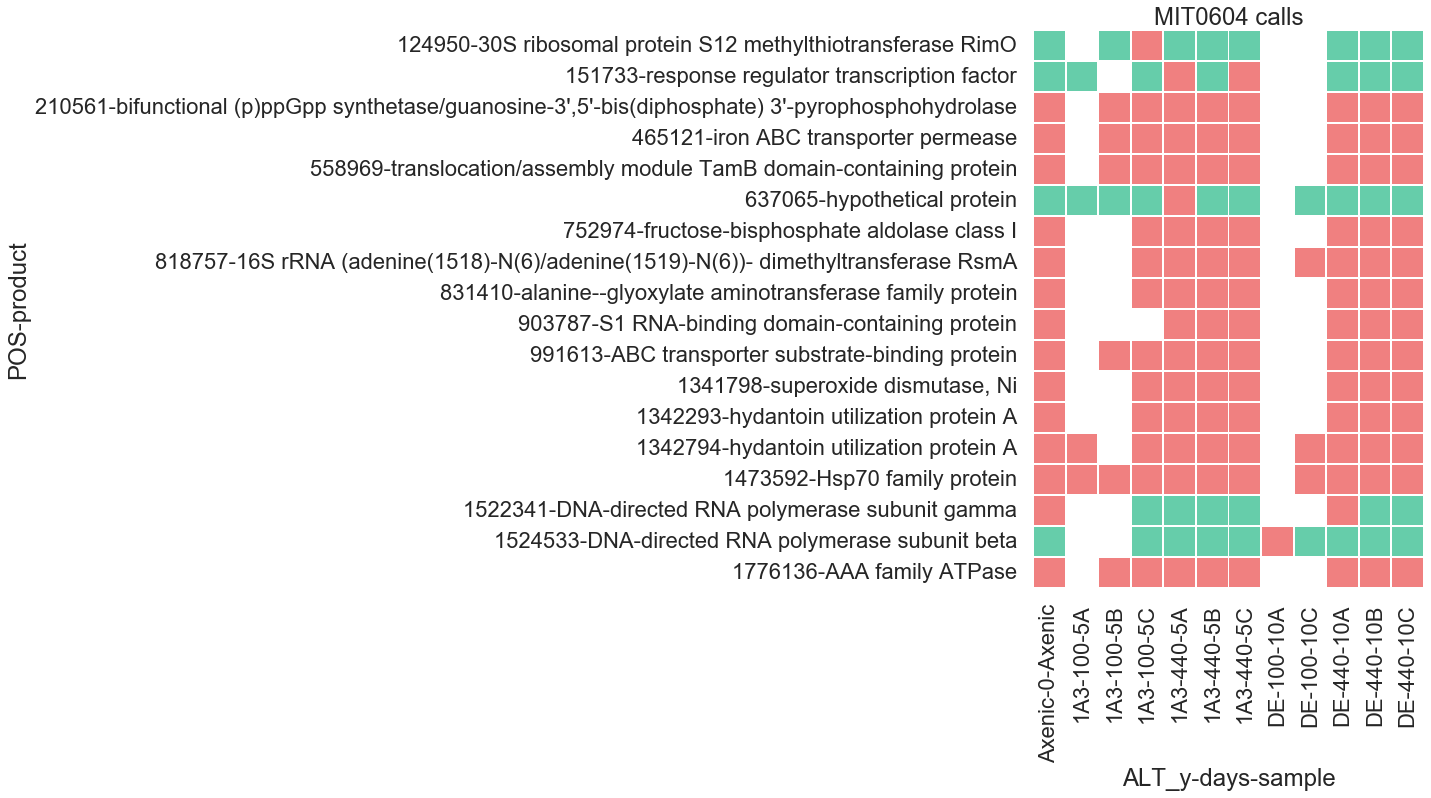

In [49]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1, 'MIT0604 calls')

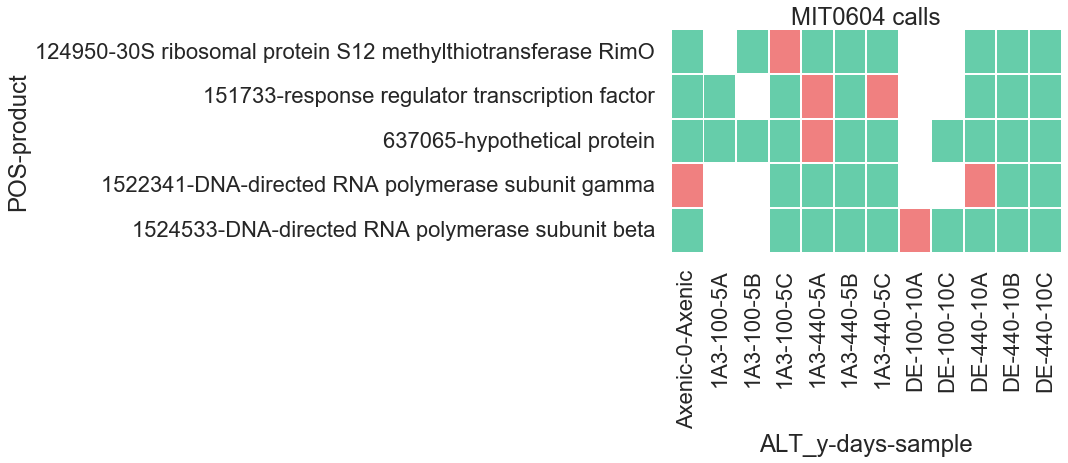

In [50]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS','product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1, 'Fraction of Alternate Allele')

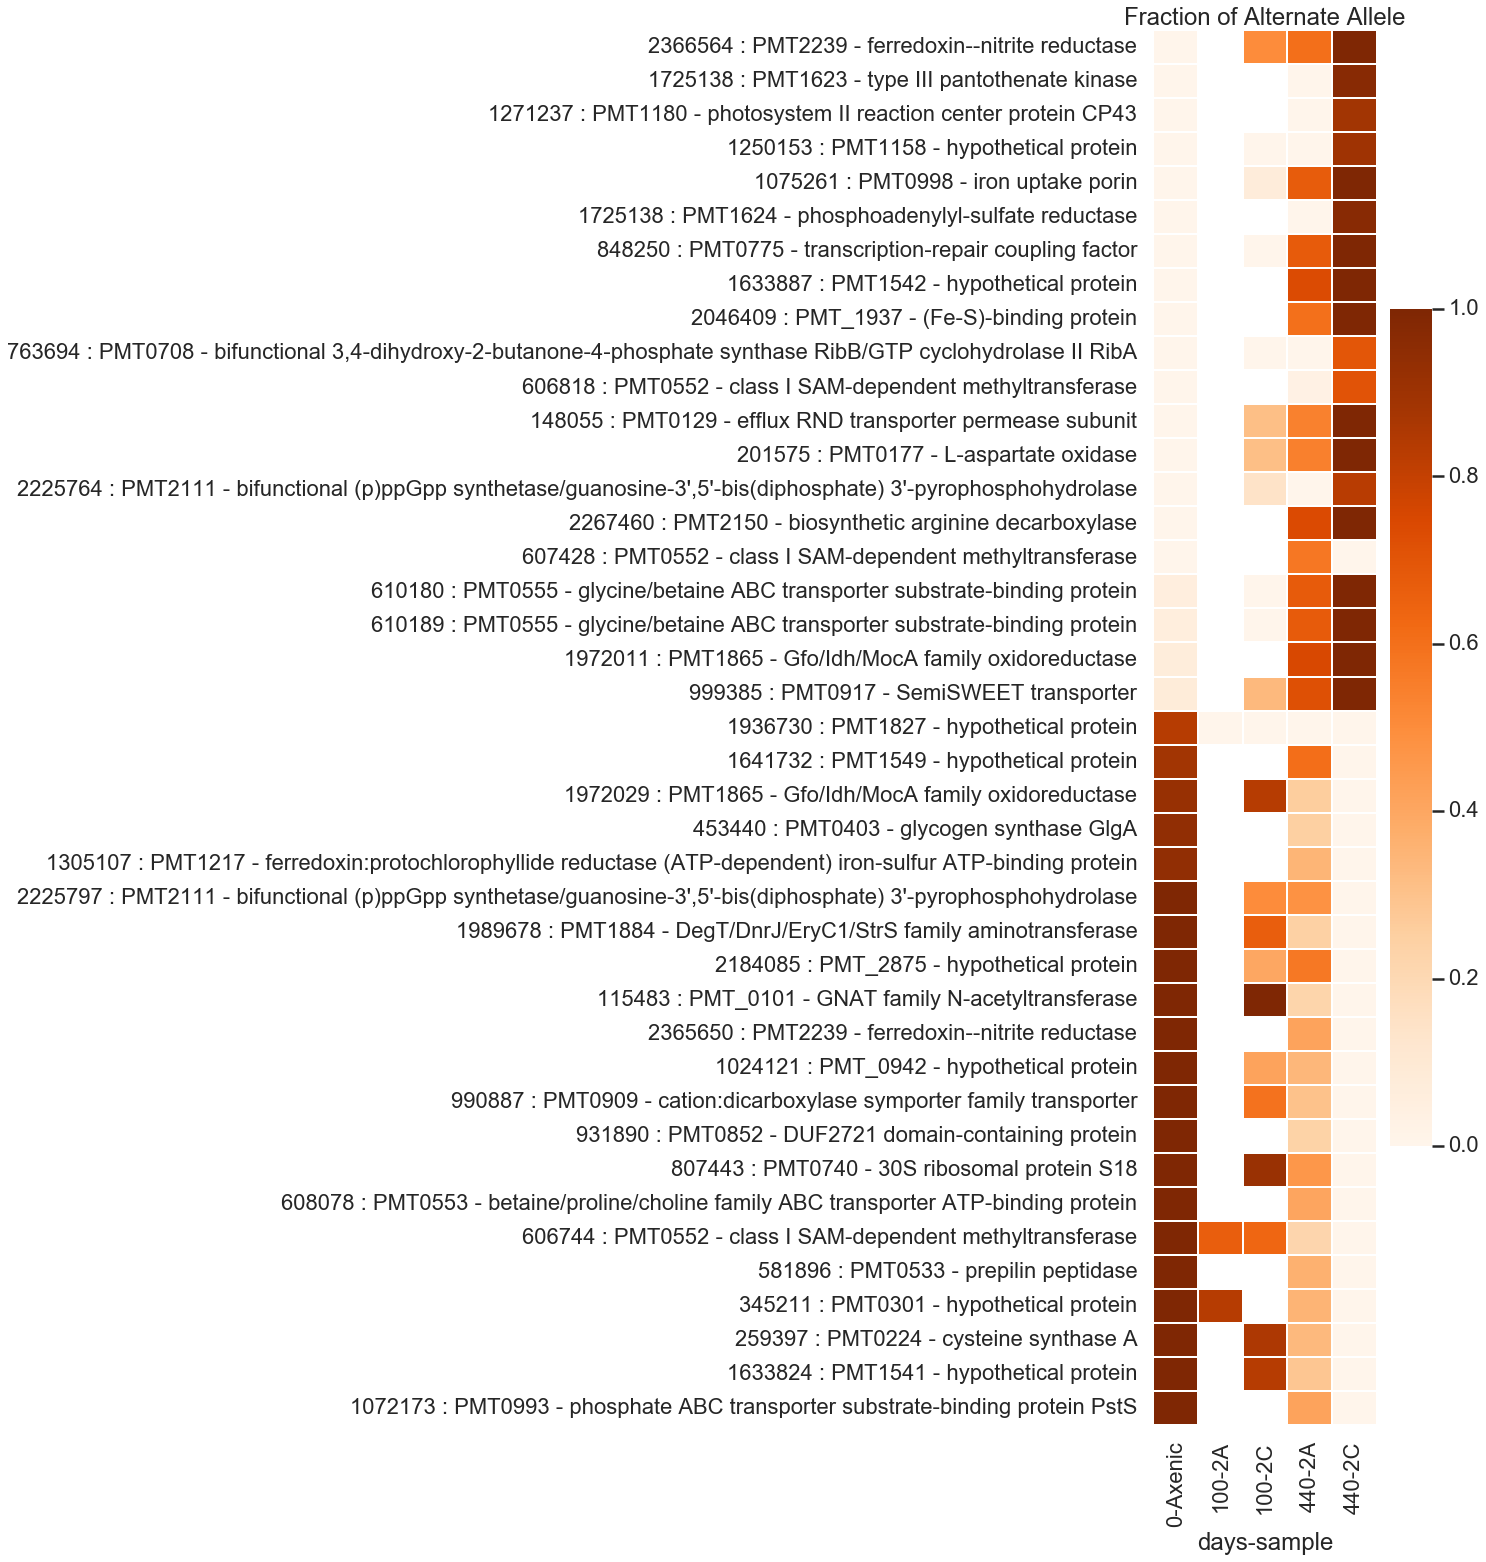

In [51]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1].sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title('Fraction of Alternate Allele')

Text(0.5, 1, 'MIT0604: fraction of Alternate Allele')

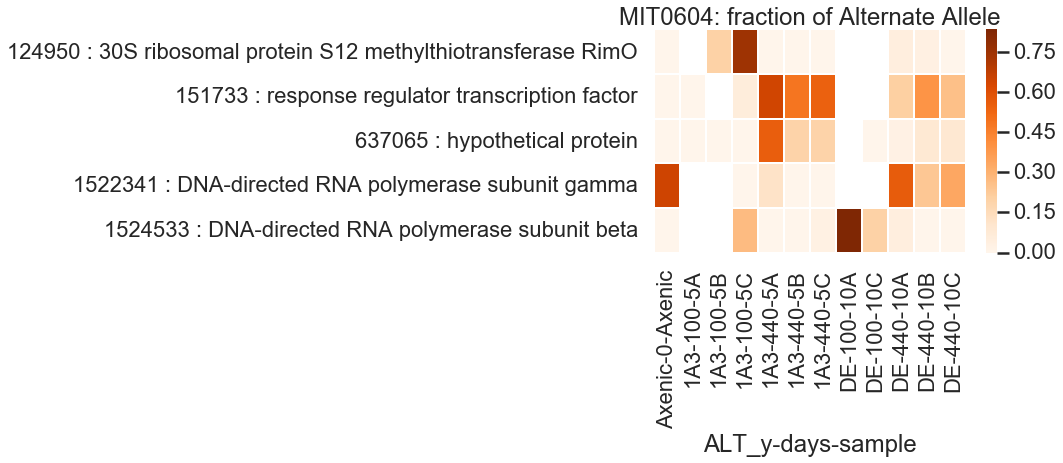

In [52]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

Text(0.5, 1, 'MIT0604: fraction of Alternate Allele')

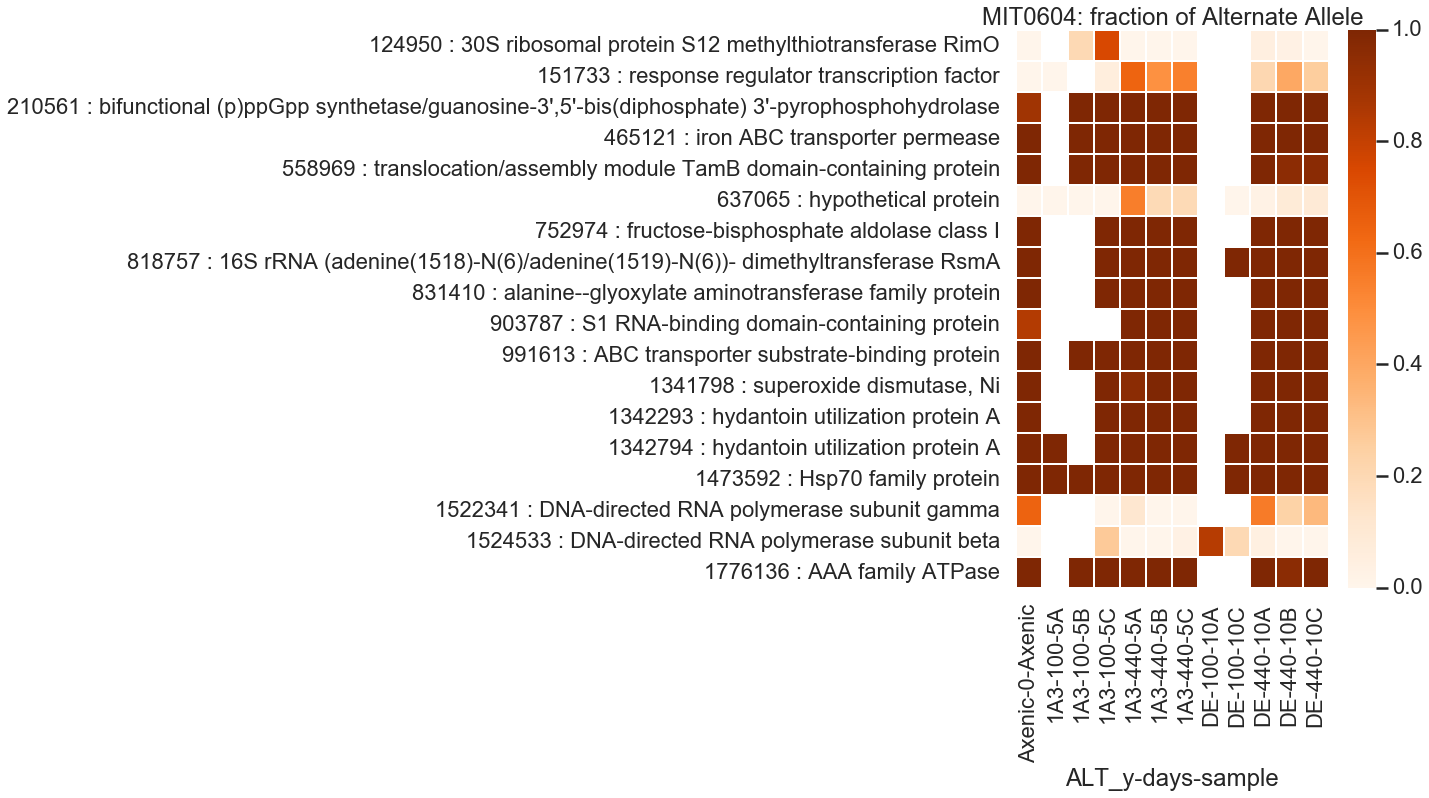

In [53]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species)
               ].pivot_table(index=[ 'POS', 'product',], 
                             columns=[ 'ALT_y', 'days','sample',], 
                             values='fraction_Alt', aggfunc='first', #dropna=False
                            )
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

In [54]:
pvdf.head()

ALT_y                                              Axenic 1A3                \
days                                                  0   100        440      
sample                                             Axenic  5A  5B 5C  5A 5B   
124950 : 30S ribosomal protein S12 methylthiotr...      0 nan   0  1   0  0   
151733 : response regulator transcription factor        0   0 nan  0   1  0   
210561 : bifunctional (p)ppGpp synthetase/guano...      1 nan   1  1   1  1   
465121 : iron ABC transporter permease                  1 nan   1  1   1  1   
558969 : translocation/assembly module TamB dom...      1 nan   1  1   1  1   

ALT_y                                                  DE                  
days                                                  100     440          
sample                                             5C 10A 10C 10A 10B 10C  
124950 : 30S ribosomal protein S12 methylthiotr...  0 nan nan   0   0   0  
151733 : response regulator transcription factor    1 nan nan   0   0   0  
210561 : bifunctional (p)ppGpp synthetase/guano...  1 nan nan   1   1   1  
465121 : iron ABC transporter permease              1 nan nan   1   1   1  
558969 : translocation/assembly module TamB dom...  1 nan nan   1   1   1

In [57]:
import urllib.parse
import urllib.request
import io

import requests, sys
# go terms for all mit9313 genes
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : 'taxonomy:74547',
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
mit9313_go_df1 = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [58]:
mit9313_go_df1.shape

(2834, 9)

In [59]:
mmit9313_go_df1 = mit9313_go_df1.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [60]:
s = mmit9313_go_df1['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df3 = mmit9313_go_df1.loc[i].copy()
df3["GO term"] = s.values
df3[["GO term", 'GOid']] = df3["GO term"].str.split(r' \[G', expand=True)
df3['GOid'] = df3['GOid'].str.replace(']', '')
df3['GOid'] = df3['GOid'].str.replace('O:', 'GO:')

In [61]:
import requests, sys
import json
goterms = df3['GOid'].unique().tolist()
json_rec = list()
step=500
for i in range(0,len(goterms)-1,step):
    termsstr = ','.join(goterms[i:i+step])
    requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
    responseBody = r.text
    #print(responseBody)
    json_rec.append(json.loads(responseBody))

len(json_rec)

3

In [62]:
len(goterms)

1160

In [63]:
ancestor_ids = {j for l in json_rec for i in l['results'] for j in i.get('ancestors', [])}


In [64]:
len(ancestor_ids)

2417

In [65]:
import requests, sys

ancestor_ids = list(ancestor_ids)
ancestor_json_rec = list()
step=500
for i in range(0,len(ancestor_ids)-1,step):
    ancestorsstr = ','.join(ancestor_ids[i:i+step])
    requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
      r.raise_for_status()

    responseBody = r.text
    ancestor_json_rec.append(json.loads(responseBody))
ancestor_names = {i['id'] : i['name'] for l in ancestor_json_rec for i in l['results'] }


In [66]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names.get(j,np.NaN)
    } 
    for l in json_rec for i in l['results'] for j in i.get('ancestors', [])]



In [67]:
df3 = pd.merge(df3, pd.DataFrame(ancestors), on='GOid', how='left')

In [68]:
all_go_df = df3

In [69]:
species = 'MIT9313'
protein_ids = dfs[species].loc[dfs[species].type == 'CDS','protein_id'].unique()


In [70]:
len(protein_ids)

61

In [71]:
pstr = ' '.join([p for p in protein_ids.tolist() if p != ''])

In [72]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'P_REFSEQ_AC',
'to': 'ACC',
'format': 'tab',
'query': pstr
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
pid2unip_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [73]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'UPARC',
'to': 'ACC',
'format': 'tab',
'query': '\n'.join(pid2unip_df.To.unique().tolist())
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
acc2id_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [74]:
acc2id_df.index = acc2id_df.From
pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'] = \
    pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'].map(acc2id_df.To)


In [75]:
pid2unip_df.shape

(73, 2)

In [76]:
unip_lst = 'accession:' + ' OR accession:'.join(pid2unip_df.To.unique().tolist())
unip_lst

'accession:Q7V968 OR accession:Q7V957 OR accession:Q7V933 OR accession:Q7V8Z3 OR accession:A0A163EME4 OR accession:A0A163S2P6 OR accession:A0A163VMQ3 OR accession:Q7V8V1 OR accession:Q7V8S5 OR accession:Q7V8S4 OR accession:Q7V8R1 OR accession:Q7V8N6 OR accession:A0A162E0T5 OR accession:Q7V8K6 OR accession:Q7V8J9 OR accession:Q7V8F0 OR accession:Q7V8D1 OR accession:Q7V861 OR accession:Q7V840 OR accession:Q7V822 OR accession:UPI0002DC8400 OR accession:UPI0012FE9E81 OR accession:UPI00059C8F3B OR accession:Q7TV00 OR accession:UPI0012FF35DC OR accession:A0A0A2CGP8 OR accession:A0A162DVP7 OR accession:A0A163D3F3 OR accession:A0A163D7F0 OR accession:A0A163Q2W7 OR accession:A0A163UPZ6 OR accession:Q7TUZ8 OR accession:Q7V7H1 OR accession:Q7V7G6 OR accession:Q7V7E4 OR accession:UPI0012FF138F OR accession:Q7V7A2 OR accession:Q7V749 OR accession:UPI00059D92E7 OR accession:Q7V721 OR accession:Q7V6Y4 OR accession:Q7V6Y2 OR accession:B9ES17 OR accession:Q7V6K1 OR accession:Q7V6H9 OR accession:Q7V6E7 

In [77]:
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : unip_lst,
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
uni2go_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [78]:
uni2go_df.shape

(64, 9)

In [79]:
uni2go_df = uni2go_df.loc[uni2go_df['Organism'].isin(['Prochlorococcus marinus (strain MIT 9313)'])]

uni2go_df.columns

Index(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism',
       'Length', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [80]:
uni2go_df.shape

(50, 9)

In [81]:
# todo think about merging with these additional go terms
additional_goterms = pd.read_excel(os.path.join('DNA', 'genomes', 'MIT93913_uniparc2go.xlsx'))

In [82]:
mdf = uni2go_df.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [83]:
mdf.head()

Entry  Entry name                                      Protein names  \
0  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
1  Q7V5P1  RPOB_PROMM  DNA-directed RNA polymerase subunit beta (RNAP...   
2  Q7TUZ8  RS18_PROMM                          30S ribosomal protein S18   
3  Q7V4J7  PSAC_PROMM  Photosystem I iron-sulfur center (EC 1.97.1.12...   
4  Q7V606   PNP_PROMM  Polyribonucleotide nucleotidyltransferase (EC ...   

            Gene names                                   Organism  Length  \
0        chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
1        rpoB PMT_1507  Prochlorococcus marinus (strain MIT 9313)    1097   
2  rpsR rps18 PMT_0740  Prochlorococcus marinus (strain MIT 9313)      73   
3        psaC PMT_1954  Prochlorococcus marinus (strain MIT 9313)      81   
4         pnp PMT_1377  Prochlorococcus marinus (strain MIT 9313)     723   

                            GO aspect  \
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   
4  Gene ontology (biological process)   

                                             GO term  
0  light-independent chlorophyll biosynthetic pro...  
1          transcription, DNA-templated [GO:0006351]  
2                           translation [GO:0006412]  
3  photosynthetic electron transport in photosyst...  
4  mRNA catabolic process [GO:0006402]; RNA proce...

In [84]:
s = mdf['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df2 = mdf.loc[i].copy()
df2["GO term"] = s.values
df2[["GO term", 'GOid']] = df2["GO term"].str.split(r' \[', expand=True)
df2['GOid'] = df2['GOid'].str.replace(']', '')

In [85]:
import requests, sys
import json
goterms = df2['GOid'].unique().tolist()
termsstr = ','.join(goterms)

requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
#print(responseBody)
json_rec = json.loads(responseBody)


In [86]:
ancestor_ids = {j for i in json_rec['results']for j in i['ancestors'] }

In [87]:
len(ancestor_ids)

480

In [88]:
import requests, sys

ancestorsstr = ','.join(ancestor_ids)
requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
ancestor_json_rec = json.loads(responseBody)
ancestor_json_rec
ancestor_names = []
ancestor_names = {i['id'] : i['name'] for i in ancestor_json_rec['results'] }


In [89]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names[j]
    } for i in json_rec['results']for j in i['ancestors'] ]



In [90]:
df2.head()

Entry  Entry name                                      Protein names  \
0  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
0  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
1  Q7V5P1  RPOB_PROMM  DNA-directed RNA polymerase subunit beta (RNAP...   
2  Q7TUZ8  RS18_PROMM                          30S ribosomal protein S18   
3  Q7V4J7  PSAC_PROMM  Photosystem I iron-sulfur center (EC 1.97.1.12...   

            Gene names                                   Organism  Length  \
0        chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
0        chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
1        rpoB PMT_1507  Prochlorococcus marinus (strain MIT 9313)    1097   
2  rpsR rps18 PMT_0740  Prochlorococcus marinus (strain MIT 9313)      73   
3        psaC PMT_1954  Prochlorococcus marinus (strain MIT 9313)      81   

                            GO aspect  \
0  Gene ontology (biological process)   
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   

                                             GO term        GOid  
0  light-independent chlorophyll biosynthetic pro...  GO:0036068  
0                      photosynthesis, dark reaction  GO:0019685  
1                       transcription, DNA-templated  GO:0006351  
2                                        translation  GO:0006412  
3  photosynthetic electron transport in photosyst...  GO:0009773

In [91]:
df2 = pd.merge(df2, pd.DataFrame(ancestors), on='GOid', how='left')

In [92]:
df2.drop_duplicates(['Entry name', 'GO aspect', 'GO term']).groupby(['GO aspect', 'GO term'])['Entry'].count().reset_index().nlargest(10, 'Entry')

GO aspect  \
35  Gene ontology (cellular component)   
34  Gene ontology (cellular component)   
80  Gene ontology (molecular function)   
43  Gene ontology (molecular function)   
38  Gene ontology (cellular component)   
42  Gene ontology (molecular function)   
17  Gene ontology (biological process)   
29  Gene ontology (biological process)   
33  Gene ontology (cellular component)   
41  Gene ontology (cellular component)   

                                           GO term  Entry  
35                  integral component of membrane     11  
34                                       cytoplasm      6  
80                               metal ion binding      5  
43                                     ATP binding      4  
38                                 plasma membrane      3  
42                4 iron, 4 sulfur cluster binding      3  
17                                     methylation      2  
29                                     translation      2  
33  ATP-binding cassette (ABC) transporter complex      2  
41                              thylakoid membrane      2

In [93]:
df2.drop_duplicates(['Entry name', 'GO aspect',  'ancestor GO term']).groupby(['GO aspect',  'ancestor GO term'])['Entry'].count().reset_index().nlargest(60, 'Entry')

GO aspect  \
438  Gene ontology (molecular function)   
33   Gene ontology (biological process)   
359  Gene ontology (molecular function)   
276  Gene ontology (cellular component)   
73   Gene ontology (biological process)   
130  Gene ontology (biological process)   
275  Gene ontology (cellular component)   
67   Gene ontology (biological process)   
342  Gene ontology (molecular function)   
344  Gene ontology (molecular function)   
170  Gene ontology (biological process)   
139  Gene ontology (biological process)   
200  Gene ontology (biological process)   
283  Gene ontology (cellular component)   
421  Gene ontology (molecular function)   
431  Gene ontology (molecular function)   
34   Gene ontology (biological process)   
56   Gene ontology (biological process)   
168  Gene ontology (biological process)   
278  Gene ontology (cellular component)   
282  Gene ontology (cellular component)   
564  Gene ontology (molecular function)   
411  Gene ontology (molecular function)   
459  Gene ontology (molecular function)   
70   Gene ontology (biological process)   
174  Gene ontology (biological process)   
376  Gene ontology (molecular function)   
279  Gene ontology (cellular component)   
362  Gene ontology (molecular function)   
433  Gene ontology (molecular function)   
53   Gene ontology (biological process)   
66   Gene ontology (biological process)   
68   Gene ontology (biological process)   
109  Gene ontology (biological process)   
128  Gene ontology (biological process)   
167  Gene ontology (biological process)   
172  Gene ontology (biological process)   
248  Gene ontology (biological process)   
336  Gene ontology (molecular function)   
373  Gene ontology (molecular function)   
145  Gene ontology (biological process)   
463  Gene ontology (molecular function)   
467  Gene ontology (molecular function)   
468  Gene ontology (molecular function)   
503  Gene ontology (molecular function)   
548  Gene ontology (molecular function)   
64   Gene ontology (biological process)   
92   Gene ontology (biological process)   
126  Gene ontology (biological process)   
277  Gene ontology (cellular component)   
349  Gene ontology (molecular function)   
443  Gene ontology (molecular function)   
29   Gene ontology (biological process)   
44   Gene ontology (biological process)   
107  Gene ontology (biological process)   
161  Gene ontology (biological process)   
165  Gene ontology (biological process)   
178  Gene ontology (biological process)   
274  Gene ontology (cellular component)   
291  Gene ontology (cellular component)   

                                     ancestor GO term  Entry  
438                                molecular_function     36  
33                                 biological_process     26  
359                                catalytic activity     26  
276                                cellular_component     23  
73                                   cellular process     22  
130                                 metabolic process     22  
275                        cellular anatomical entity     22  
67                         cellular metabolic process     19  
342                                           binding     19  
344                                biological_process     19  
170               organic substance metabolic process     17  
139               nitrogen compound metabolic process     16  
200                         primary metabolic process     16  
283                                          membrane     15  
421                                       ion binding     15  
431                                 metabolic process     15  
34                               biosynthetic process     14  
56                      cellular biosynthetic process     14  
168            organic substance biosynthetic process     13  
278                    integral component of membrane     13  
282                   intrinsic component of membrane     13  
564                 

In [94]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1



In [95]:
go_df = pd.merge(pid2unip_df, df2, left_on='To', right_on='Entry', how='right')

In [96]:
go_df = pd.merge(pvdf.droplevel(axis=1, level=1), go_df, left_on='protein_id', right_on='From', how='left')

In [97]:
# remove pseudo genes
go_df = go_df.loc[go_df.protein_id != '']
go_df.head(10)

protein_id        gene_id                                  product  0  \
7   WP_011129469.1  AKG35_RS00470                     hypothetical protein  1   
8   WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
9   WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
10  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
11  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
12  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
13  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
14  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
15  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
16  WP_011129508.1  AKG35_RS00645  efflux RND transporter permease subunit  0   

    100  100  440  440  actual_snp            From  ...    Entry name  \
7   nan    1    1    1       False             NaN  ...           NaN   
8   nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
9   nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
10  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
11  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
12  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
13  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
14  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
15  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
16  nan    0    1    1        True  WP_011129508.1  ...  Q7V933_PROMM   

                                       Protein names Gene names  \
7                                                NaN        NaN   
8                                  Acetyltransferase   PMT_0101   
9                                  Acetyltransferase   PMT_0101   
10                                 Acetyltransferase   PMT_0101   
11                                 Acetyltransferase   PMT_0101   
12                                 Acetyltransferase   PMT_0101   
13                                 Acetyltransferase   PMT_0101   
14                                 Acetyltransferase   PMT_0101   
15                                 Acetyltransferase   PMT_0101   
16  Putative RND family multidrug efflux transporter   PMT_0129   

                                     Organism Length  \
7                                         NaN    nan   
8   Prochlorococcus marinus (strain MIT 9313)    179   
9   Prochlorococcus marinus (strain MIT 9313)    179   
10  Prochlorococcus marinus (strain MIT 9313)    179   
11  Prochlorococcus marinus (strain MIT 9313)    179   
12  Prochlorococcus marinus (strain MIT 9313)    179   
13  Prochlorococcus marinus (strain MIT 9313)    179   
14  Prochlorococcus marinus (strain MIT 9313)    179   
15  Prochlorococcus marinus (strain MIT 9313)    179   
16  Prochlorococcus marinus (strain MIT 9313)   1086   

                             GO aspect                         GO term  \
7                                  NaN                             NaN   
8   Gene ontology (molecular function)    N-acetyltransferase activity   
9   Gene ontology (molecular function)    N-acetyltransferase activity   
10  Gene ontology (molecular function)    N-acetyltransferase activity   
11  Gene ontology (molecular function)    N-acetyltransferase activity   
12  Gene ontology (molecular function)    N-acetyltransferase activity   
13  Gene ontology (molecular function)    N-acetyltransferase activity   
14  Gene ontology (molecular function)    N-acetyltransferase activity   
15  Gene ontology (molecular function)    N-acetyltransferase activity   
16  Gene ontology (cellular component)  integral component of membrane   

          GOid  ancestorID                                   ancestor GO term  
7          NaN         NaN                                    

In [98]:
go_df.loc[go_df['Entry name'].isna()
          , ['protein_id', 'gene_id', 'product']]
#print('\n'.join(go_df.loc[go_df['Entry name'].isna() , ]['protein_id'].unique().tolist()))

protein_id        gene_id  \
7     WP_011129469.1  AKG35_RS00470   
247   WP_011129680.1  AKG35_RS01605   
1431  WP_011130908.1  AKG35_RS08200   
1432  WP_011130909.1  AKG35_RS08205   
1438  WP_011130986.1  AKG35_RS08630   
1628  WP_011131506.1  AKG35_RS11410   
1734  WP_041375225.1  AKG35_RS09985   
1735  WP_041384309.1  AKG35_RS02915   
1736  WP_041384560.1  AKG35_RS07800   
1737  WP_041384967.1  AKG35_RS03695   
1738  WP_041385020.1  AKG35_RS04825   
1739  WP_041385260.1  AKG35_RS11050   
1740  WP_157859810.1  AKG35_RS04360   
1741  WP_157859846.1  AKG35_RS06170   
1742  WP_157859934.1  AKG35_RS02925   
1743  WP_157859940.1  AKG35_RS03835   
1744  WP_157859964.1  AKG35_RS08240   

                                                product  
7                                  hypothetical protein  
247                                hypothetical protein  
1431                               hypothetical protein  
1432                               hypothetical protein  
1438                               hypothetical protein  
1628                               hypothetical protein  
1734                 Gfo/Idh/MocA family oxidoreductase  
1735  betaine/proline/choline family ABC transporter...  
1736                                      NAD+ synthase  
1737  bifunctional 3,4-dihydroxy-2-butanone-4-phosph...  
1738                              SemiSWEET transporter  
1739                               hypothetical protein  
1740                               hypothetical protein  
1741                               hypothetical protein  
1742  glycine/betaine ABC transporter substrate-bind...  
1743                             DUF3370 family protein  
1744                               hypothetical protein

In [99]:
print( 'Total number of genes with SNP')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id','actual_snp']).groupby('actual_snp')['gene_id'].count()

Total number of genes with SNP


actual_snp
False    25
True     35
Name: gene_id, dtype: int64

In [100]:
print('Genes with SNP, that have uniprot and go terms')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id', 'actual_snp']).groupby('actual_snp')['To'].count()

Genes with SNP, that have uniprot and go terms


actual_snp
False    18
True     25
Name: To, dtype: int64

In [101]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(10, ('Entry', True))

GO aspect  \
actual_snp                                       
35          Gene ontology (cellular component)   
80          Gene ontology (molecular function)   
34          Gene ontology (cellular component)   
17          Gene ontology (biological process)   
42          Gene ontology (molecular function)   
43          Gene ontology (molecular function)   
1           Gene ontology (biological process)   
2           Gene ontology (biological process)   
4           Gene ontology (biological process)   
5           Gene ontology (biological process)   

                                        GO term Entry       
actual_snp                                      False True  
35               integral component of membrane     4    7  
80                            metal ion binding     1    4  
34                                    cytoplasm     3    3  
17                                  methylation   nan    2  
42             4 iron, 4 sulfur cluster binding     1    2  
43                                  ATP binding     2    2  
1           L-glutamate transmembrane transport   nan    1  
2                      NAD biosynthetic process   nan    1  
4                    arginine catabolic process   nan    1  
5             aspartate transmembrane transport   nan    1

In [102]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'ancestor GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'ancestor GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(15, ('Entry', True))

GO aspect  \
actual_snp                                       
438         Gene ontology (molecular function)   
33          Gene ontology (biological process)   
359         Gene ontology (molecular function)   
73          Gene ontology (biological process)   
130         Gene ontology (biological process)   
275         Gene ontology (cellular component)   
276         Gene ontology (cellular component)   
344         Gene ontology (molecular function)   
67          Gene ontology (biological process)   
170         Gene ontology (biological process)   
34          Gene ontology (biological process)   
56          Gene ontology (biological process)   
200         Gene ontology (biological process)   
431         Gene ontology (molecular function)   
139         Gene ontology (biological process)   

                               ancestor GO term Entry       
actual_snp                                      False True  
438                          molecular_function    14   22  
33                           biological_process    10   16  
359                          catalytic activity    11   15  
73                             cellular process     9   13  
130                           metabolic process     9   13  
275                  cellular anatomical entity    10   12  
276                          cellular_component    11   12  
344                          biological_process     7   12  
67                   cellular metabolic process     8   11  
170         organic substance metabolic process     7   10  
34                         biosynthetic process     5    9  
56                cellular biosynthetic process     5    9  
200                   primary metabolic process     7    9  
431                           metabolic process     6    9  
139         nitrogen compound metabolic process     8    8

In [103]:
go_df.head()

protein_id        gene_id                          product  0  100  \
7   WP_011129469.1  AKG35_RS00470             hypothetical protein  1  nan   
8   WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
9   WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
10  WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
11  WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   

    100  440  440  actual_snp            From  ...    Entry name  \
7     1    1    1       False             NaN  ...           NaN   
8     1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
9     1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
10    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
11    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   

        Protein names Gene names                                   Organism  \
7                 NaN        NaN                                        NaN   
8   Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
9   Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
10  Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
11  Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   

   Length                           GO aspect                       GO term  \
7     nan                                 NaN                           NaN   
8     179  Gene ontology (molecular function)  N-acetyltransferase activity   
9     179  Gene ontology (molecular function)  N-acetyltransferase activity   
10    179  Gene ontology (molecular function)  N-acetyltransferase activity   
11    179  Gene ontology (molecular function)  N-acetyltransferase activity   

          GOid  ancestorID                                   ancestor GO term  
7          NaN         NaN                                                NaN  
8   GO:0008080  GO:0016746     transferase activity, transferring acyl groups  
9   GO:0008080  GO:0016747  transferase activity, transferring acyl groups...  
10  GO:0008080  GO:0016407                         acetyltransferase activity  
11  GO:0008080  GO:0003824                                 catalytic activity  

[5 rows x 22 columns]

In [104]:
go_df.columns

Index([      'protein_id',          'gene_id',          'product',
                        0,                100,                100,
                      440,                440,       'actual_snp',
                   'From',               'To',            'Entry',
             'Entry name',    'Protein names',       'Gene names',
               'Organism',           'Length',        'GO aspect',
                'GO term',             'GOid',       'ancestorID',
       'ancestor GO term'],
      dtype='object')

In [105]:
found_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'GO term'])[
    ['Entry name', 'GO aspect', 'GO term', 'GOid', ]].dropna()
found_ancestors_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'ancestor GO term'])[
    ['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()
all_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                            ].drop_duplicates(['Entry name', 'GO term'])[
    ['Entry name', 'GO aspect', 'GO term', 'GOid', ]].dropna()
all_ancestors_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                                      ].drop_duplicates(['Entry name', 'ancestor GO term'])[
    ['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()

In [106]:
found_goterms.columns, found_ancestors_goterms.columns

(Index(['Entry name', 'GO aspect', 'GO term', 'GOid'], dtype='object'),
 Index(['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID'], dtype='object'))

In [107]:
found_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)
all_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)


In [108]:
found_goterms1 = pd.concat([found_goterms, found_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])
all_goterms1 = pd.concat([all_goterms, all_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])


In [109]:
found_goterms1.head()

Entry name                           GO aspect  \
8   Q7V957_PROMM  Gene ontology (molecular function)   
16  Q7V933_PROMM  Gene ontology (cellular component)   
21  Q7V933_PROMM  Gene ontology (molecular function)   
30  Q7V8Z3_PROMM  Gene ontology (biological process)   
69  Q7V8Z3_PROMM  Gene ontology (cellular component)   

                               GO term        GOid  
8         N-acetyltransferase activity  GO:0008080  
16      integral component of membrane  GO:0016021  
21  transmembrane transporter activity  GO:0022857  
30            NAD biosynthetic process  GO:0009435  
69                           cytoplasm  GO:0005737

In [150]:
total_snp_entries = found_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
found_counts = found_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'SNP count'})
found_counts['rest SNP count'] =found_counts['GO aspect'].map(total_snp_entries) - found_counts['SNP count'] 

In [151]:
total_all_entries = all_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
all_counts = all_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'all count'})
all_counts['rest all count'] =total_all_entries - all_counts['all count'] 
all_counts['rest all count'] =all_counts['GO aspect'].map(total_all_entries) - all_counts['all count'] 

In [152]:
go_stats_df = pd.merge(found_counts, all_counts, 
                       on=['GO aspect', 'GO term', 'GOid'],
                      how='left'
                      )

In [153]:
go_stats_df['all count'] = go_stats_df['all count'].fillna(value=0)
go_stats_df['rest all count'] =go_stats_df['GO aspect'].map(total_all_entries) - go_stats_df['all count'] 


In [154]:
go_stats_df.head()

GO aspect  \
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   
4  Gene ontology (biological process)   

                                      GO term        GOid  SNP count  \
0                  C4-dicarboxylate transport  GO:0015740          1   
1                       DNA metabolic process  GO:0006259          1   
2                                  DNA repair  GO:0006281          1   
3  L-alpha-amino acid transmembrane transport  GO:1902475          1   
4                      L-amino acid transport  GO:0015807          1   

   rest SNP count  all count  rest all count  
0              15        0.0           843.0  
1              15       51.0           792.0  
2              15       32.0           811.0  
3              15        1.0           842.0  
4              15        1.0           842.0

In [155]:
go_stats_df['GO aspect'].value_counts()

Gene ontology (biological process)    226
Gene ontology (molecular function)    121
Gene ontology (cellular component)     26
Name: GO aspect, dtype: int64

In [156]:
go_stats_df['SNP count'].value_counts()

1     265
2      52
3      19
4       8
5       7
8       6
9       3
6       3
13      2
12      2
22      1
16      1
15      1
11      1
10      1
7       1
Name: SNP count, dtype: int64

In [165]:
MF_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (molecular function)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [166]:
MF_stats_df.shape

(121, 7)

In [167]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
MF_stats_df[['oddsratio','pvalue']] =  MF_stats_df.apply(_runfisher, axis=1)


In [168]:
MF_stats_df.nsmallest(30, 'pvalue')

GO aspect  \
255  Gene ontology (molecular function)   
256  Gene ontology (molecular function)   
257  Gene ontology (molecular function)   
269  Gene ontology (molecular function)   
271  Gene ontology (molecular function)   
272  Gene ontology (molecular function)   
289  Gene ontology (molecular function)   
294  Gene ontology (molecular function)   
296  Gene ontology (molecular function)   
297  Gene ontology (molecular function)   
298  Gene ontology (molecular function)   
314  Gene ontology (molecular function)   
319  Gene ontology (molecular function)   
329  Gene ontology (molecular function)   
334  Gene ontology (molecular function)   
339  Gene ontology (molecular function)   
355  Gene ontology (molecular function)   
263  Gene ontology (molecular function)   
273  Gene ontology (molecular function)   
274  Gene ontology (molecular function)   
287  Gene ontology (molecular function)   
295  Gene ontology (molecular function)   
328  Gene ontology (molecular function)   
333  Gene ontology (molecular function)   
304  Gene ontology (molecular function)   
310  Gene ontology (molecular function)   
337  Gene ontology (molecular function)   
359  Gene ontology (molecular function)   
327  Gene ontology (molecular function)   
260  Gene ontology (molecular function)   

                                               GO term        GOid  SNP count  \
255                      L-amino-acid oxidase activity  GO:0001716          1   
256                       L-aspartate oxidase activity  GO:0008734          1   
257       L-aspartate:fumarate oxidoreductase activity  GO:0044318          1   
269                 alpha-1,4-glucan synthase activity  GO:0033201          1   
271                    arginine decarboxylase activity  GO:0008792          1   
272                         aspartate oxidase activity  GO:0015922          1   
289          diphosphoric monoester hydrolase activity  GO:0016794          1   
294              ferredoxin-nitrite reductase activity  GO:0048307          1   
296               glycine N-methyltransferase activity  GO:0017174          1   
297                glycogen (starch) synthase activity  GO:0004373          1   
298  guanosine-3',5'-bis(diphosphate) 3'-diphosphat...  GO:0008893          1   
314                         nitrite reductase activity  GO:0098809          1   
319                        nutrient reservoir activity  GO:0045735          1   
329  oxidoreductase activity, acting on other nitro...  GO:0016664          1   
334                       pantothenate kinase activity  GO:0004594          1   
339  phosphoadenylyl-sulfate reductase (thioredoxin...  GO:0004604          1   
355                           starch synthase activity  GO:0009011          1   
263                   UDP-glucosyltransferase activity  GO:0035251          1   
273               aspartic-type endopeptidase activity  GO:0004190          1   
274                   aspartic-type peptidase activity  GO:0070001          1   
287                         cysteine synthase activity  GO:0004124          1   
295                       glucosyltransferase activity  GO:0046527          1   
328  oxidoreductase activity, acting on other nitro...  GO:0016661          1   
333  oxidoreductase activity, acting on the CH-NH2 ...  GO:0016641          1   
304                        iron-sulfur cluster binding  GO:0051536          3   
310                              metal cluster binding  GO:0051540          3   
337                              phosphate ion binding  GO:0042301          1   
359                               tetrapyrrole binding  GO:0046906          2   
327  oxidoreductase activity, acting on iron-sulfur...  GO:0016730          1   
260                       N-methyltransferase activity  GO:0008170          1   

     rest SNP count  all count  rest all count  oddsratio    pvalue  
255              21        0.0          1209.0        inf  0.017872  
256              21        0.0          1209

In [169]:
BP_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (biological process)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [170]:
BP_stats_df.shape

(226, 7)

In [171]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
BP_stats_df[['oddsratio','pvalue']] =  BP_stats_df.apply(_runfisher, axis=1)


In [172]:
BP_stats_df.nsmallest(30, 'pvalue')

GO aspect  \
19   Gene ontology (biological process)   
20   Gene ontology (biological process)   
0    Gene ontology (biological process)   
21   Gene ontology (biological process)   
24   Gene ontology (biological process)   
82   Gene ontology (biological process)   
87   Gene ontology (biological process)   
122  Gene ontology (biological process)   
169  Gene ontology (biological process)   
210  Gene ontology (biological process)   
211  Gene ontology (biological process)   
219  Gene ontology (biological process)   
220  Gene ontology (biological process)   
224  Gene ontology (biological process)   
225  Gene ontology (biological process)   
96   Gene ontology (biological process)   
3    Gene ontology (biological process)   
4    Gene ontology (biological process)   
5    Gene ontology (biological process)   
10   Gene ontology (biological process)   
17   Gene ontology (biological process)   
18   Gene ontology (biological process)   
35   Gene ontology (biological process)   
36   Gene ontology (biological process)   
73   Gene ontology (biological process)   
88   Gene ontology (biological process)   
91   Gene ontology (biological process)   
92   Gene ontology (biological process)   
127  Gene ontology (biological process)   
129  Gene ontology (biological process)   

                                               GO term        GOid  SNP count  \
19                       anion transmembrane transport  GO:0098656          2   
20                                     anion transport  GO:0006820          2   
0                           C4-dicarboxylate transport  GO:0015740          1   
21                          arginine catabolic process  GO:0006527          1   
24                   aspartate transmembrane transport  GO:0015810          1   
82       glutamine family amino acid catabolic process  GO:0009065          1   
87          guanosine tetraphosphate metabolic process  GO:0015969          1   
122  nucleotide-excision repair, DNA damage recogni...  GO:0000715          1   
169  purine ribonucleoside bisphosphate metabolic p...  GO:0034035          1   
210  sulfate assimilation, phosphoadenylyl sulfate ...  GO:0019379          1   
211                                  sulfate reduction  GO:0019419          1   
219   transcription-coupled nucleotide-excision repair  GO:0006283          1   
220  transcription-coupled nucleotide-excision repa...  GO:0000716          1   
224                    ubiquinone biosynthetic process  GO:0006744          1   
225                       ubiquinone metabolic process  GO:0006743          1   
96                         ion transmembrane transport  GO:0034220          2   
3           L-alpha-amino acid transmembrane transport  GO:1902475          1   
4                               L-amino acid transport  GO:0015807          1   
5                  L-glutamate transmembrane transport  GO:0015813          1   
10                         acidic amino acid transport  GO:0015800          1   
17                  amino acid transmembrane transport  GO:0003333          1   
18                                amino acid transport  GO:0006865          1   
35             carboxylic acid transmembrane transport  GO:1905039          1   
36                           carboxylic acid transport  GO:0046942          1   
73                         dicarboxylic acid transport  GO:0006835          1   
88     guanosine-containing compound metabolic process  GO:1901068          1   
91               hydrogen sulfide biosynthetic process  GO:0070814          1   
92                  hydrogen sulfide metabolic process  GO:0070813          1   
127               organic acid transmembrane transport  GO:1903825          1   
129                            organic anion transport  GO:0015711          1   

     rest SNP count  all count  rest all count  oddsratio    pvalue  
19               14        3.0           840.0  40.000000  0.003151  
20               14        4.0           839

Gene ontology (molecular function) (121, 22)


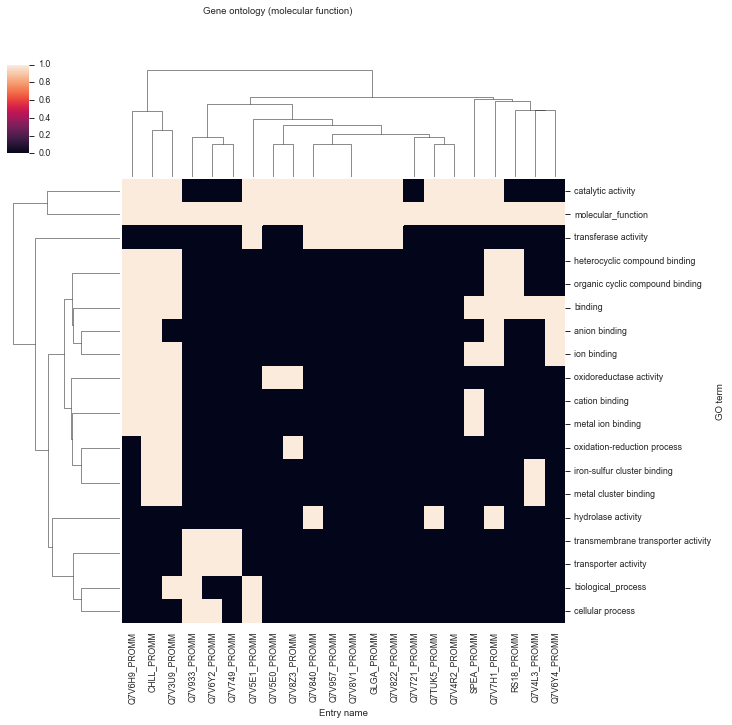

Gene ontology (cellular component) (26, 12)


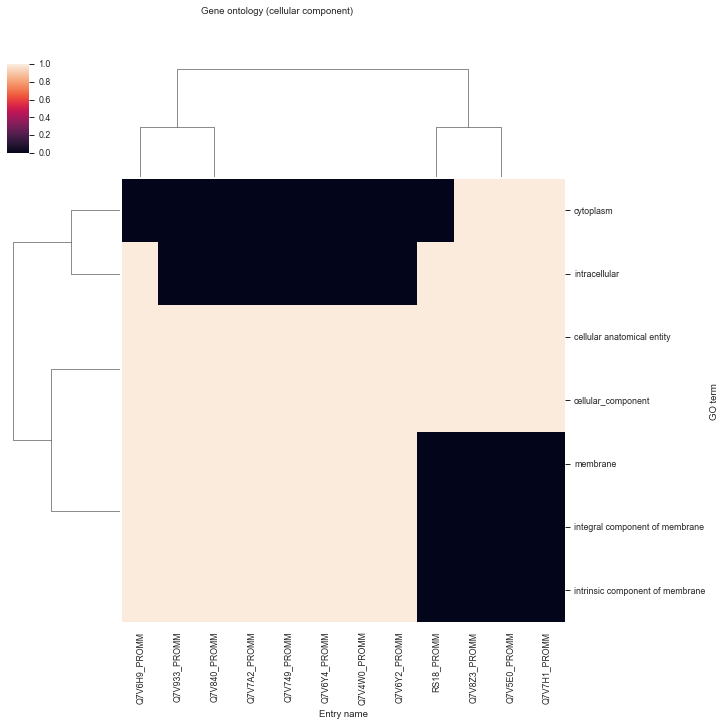

Gene ontology (biological process) (226, 16)


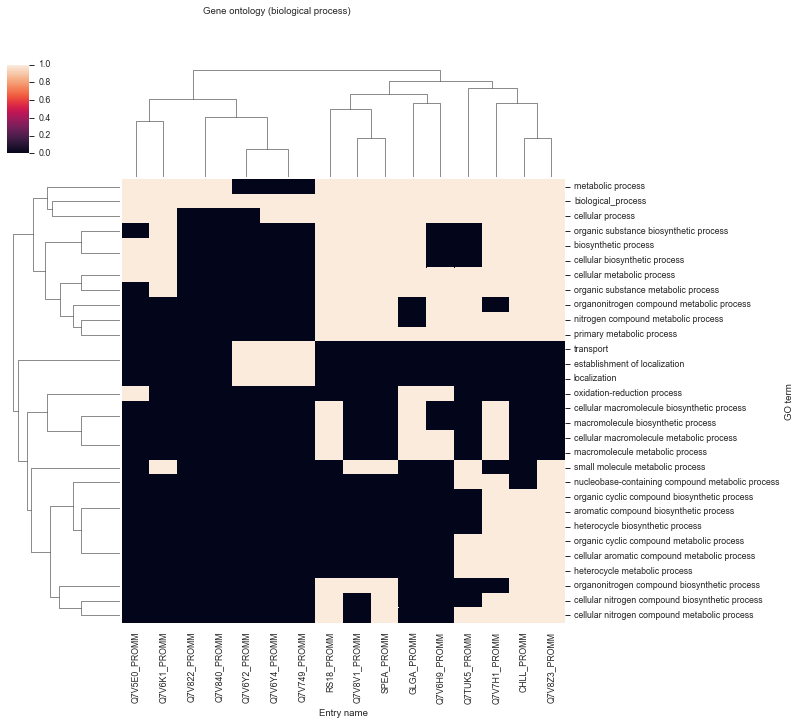

In [134]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('paper')
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1)>2]) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

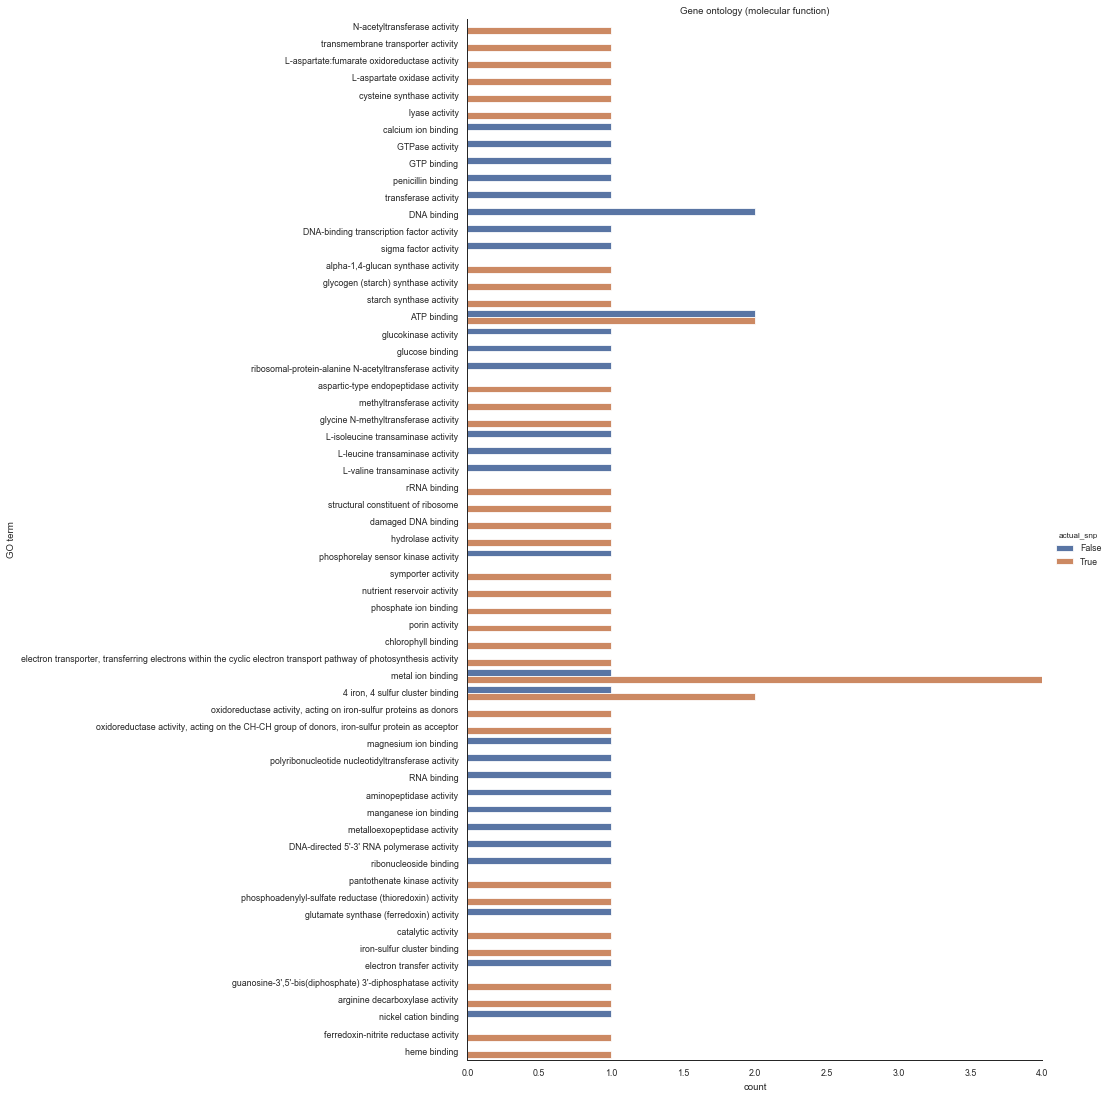

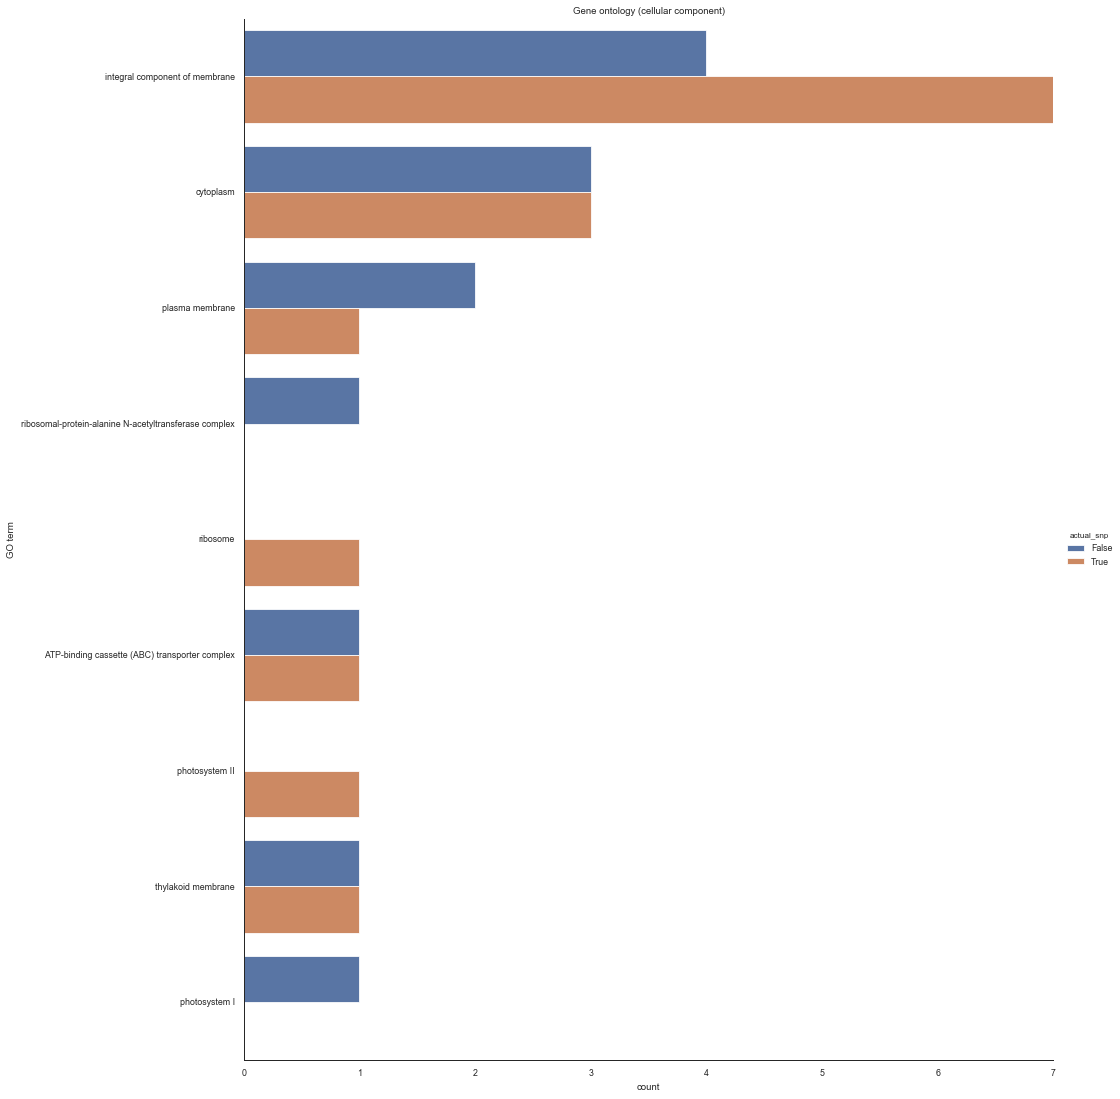

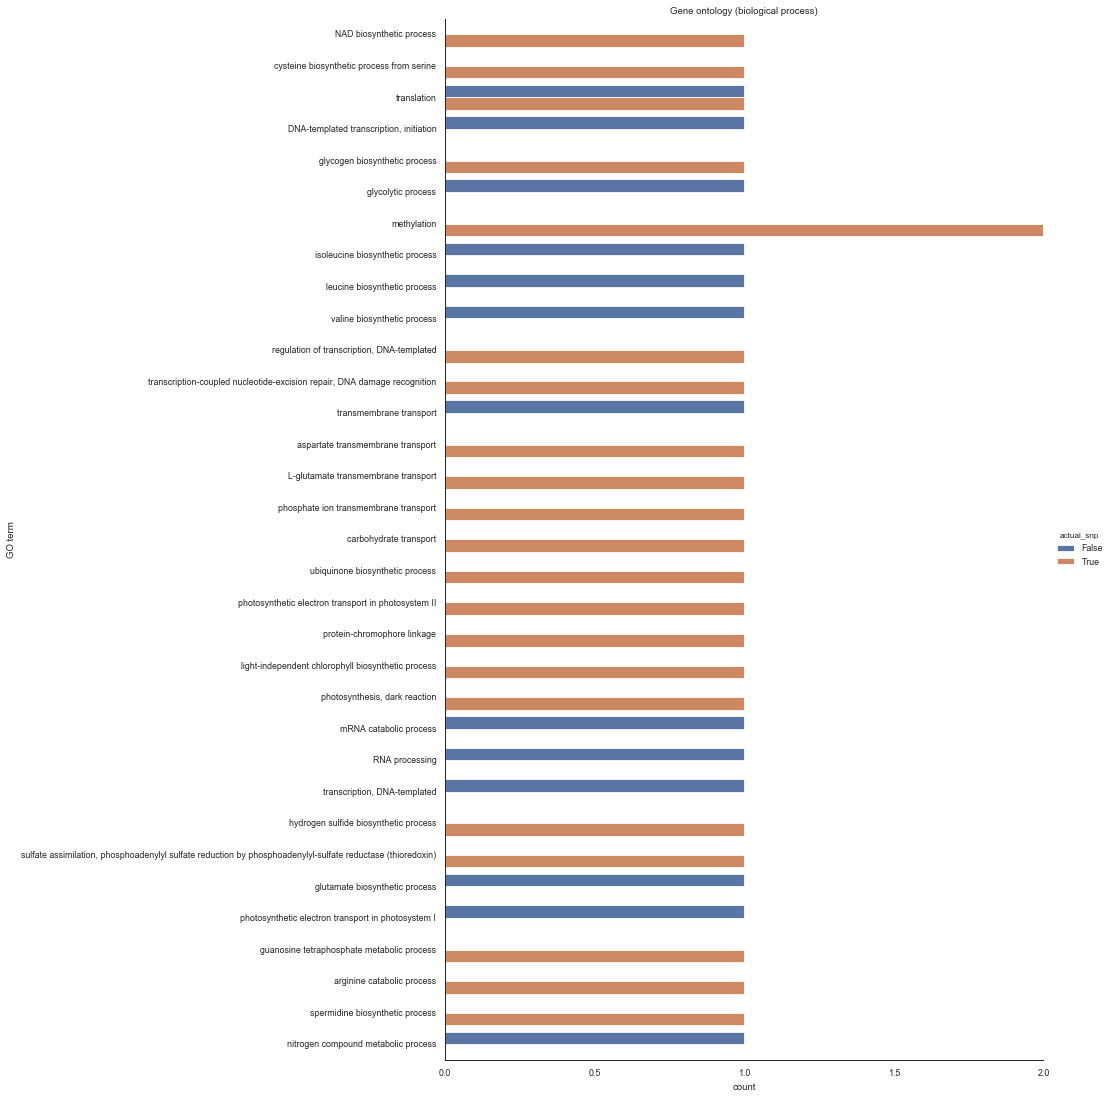

In [411]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

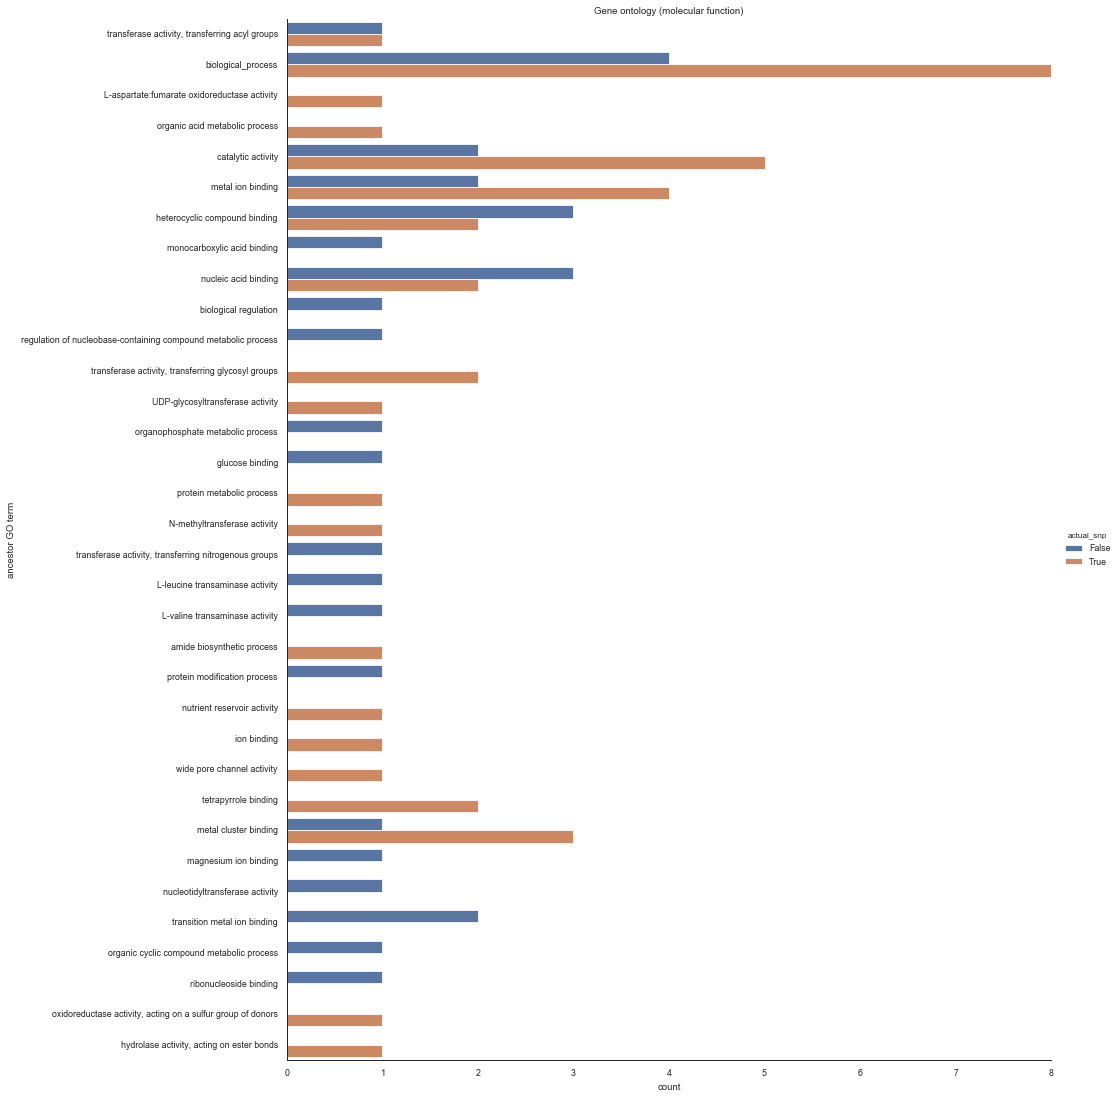

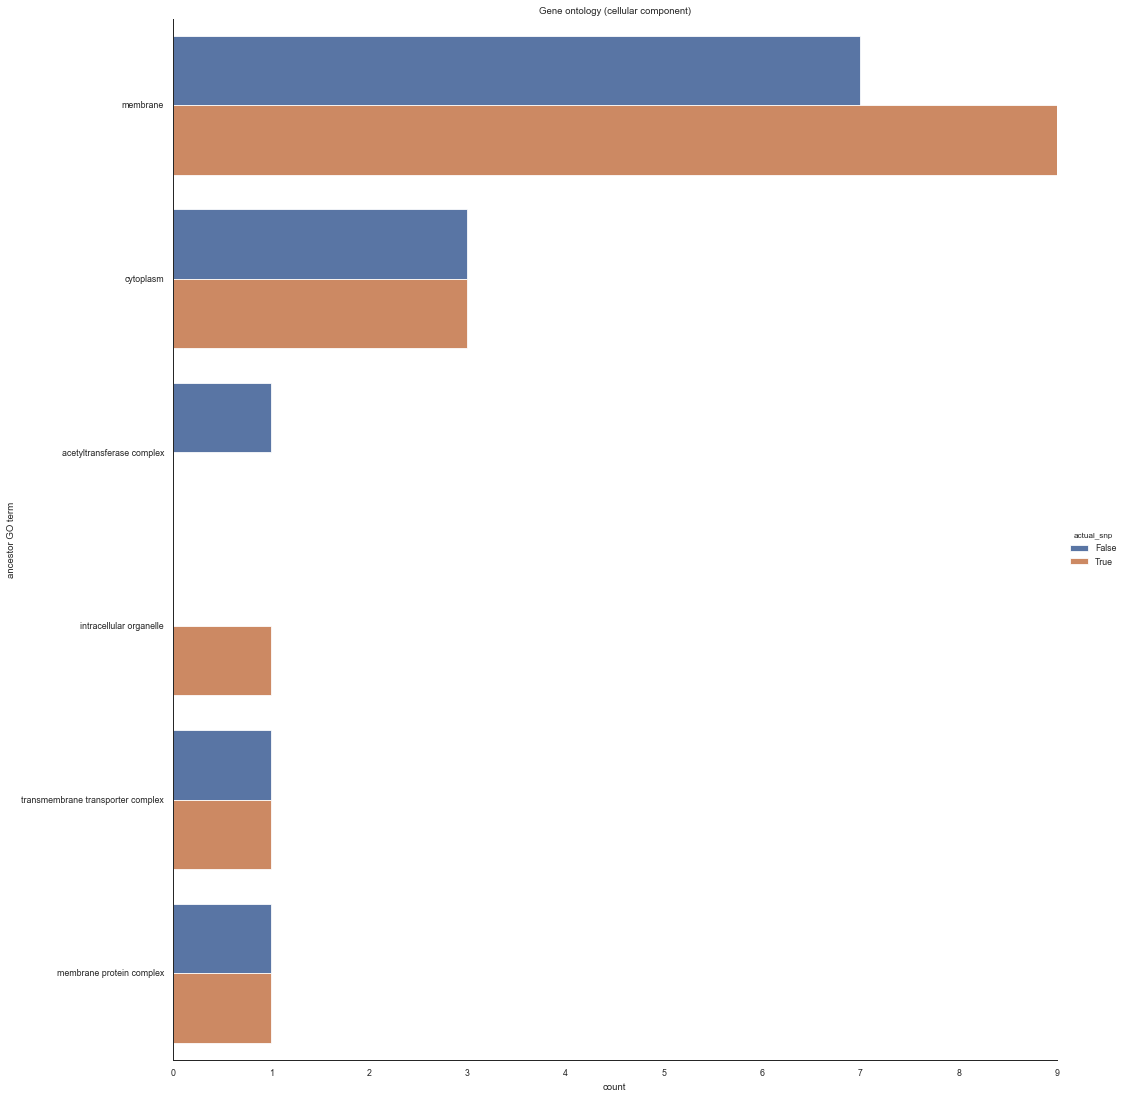

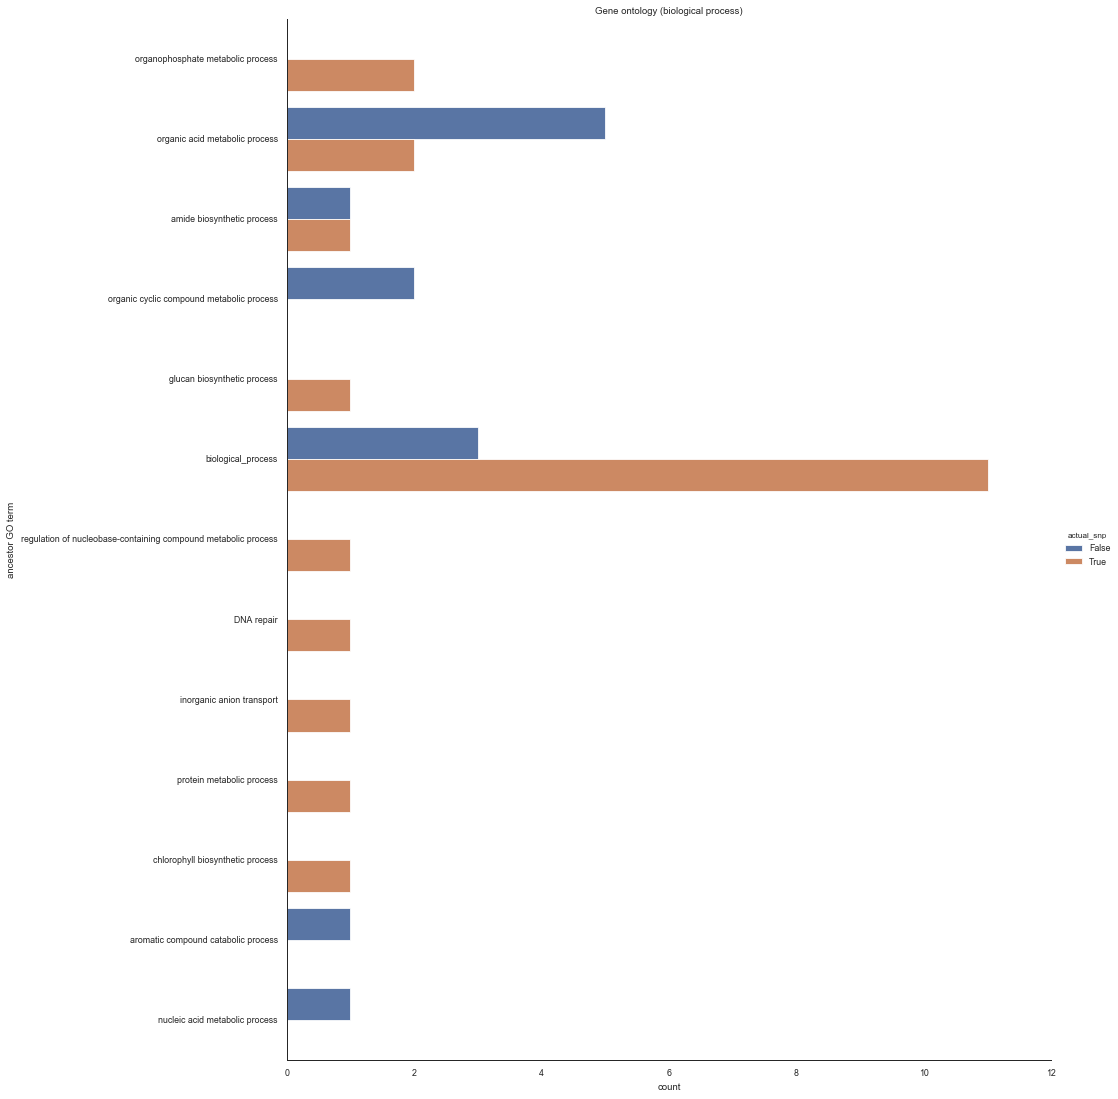

In [465]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='ancestor GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

Gene ontology (molecular function) (61, 36)


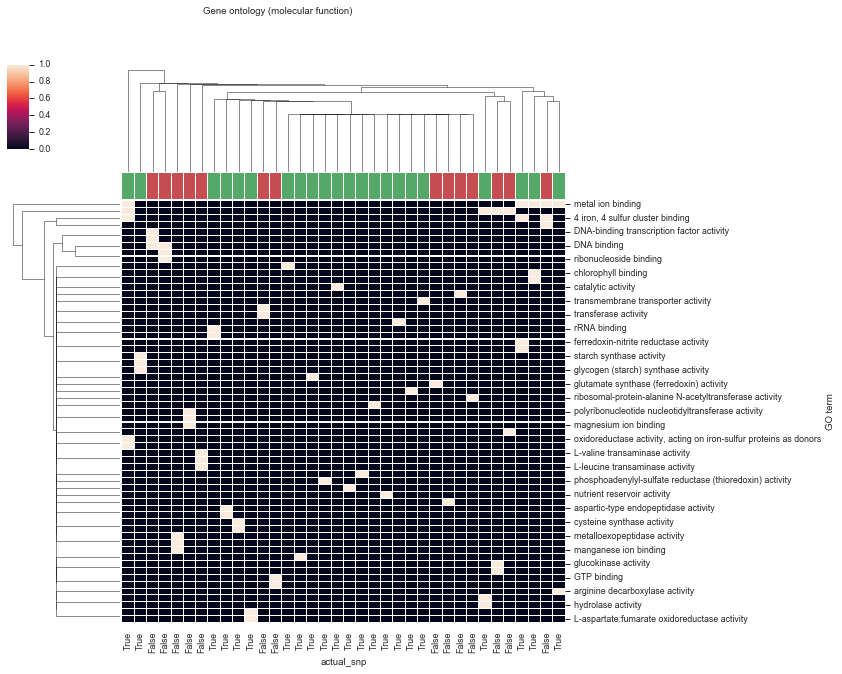

Gene ontology (cellular component) (9, 23)


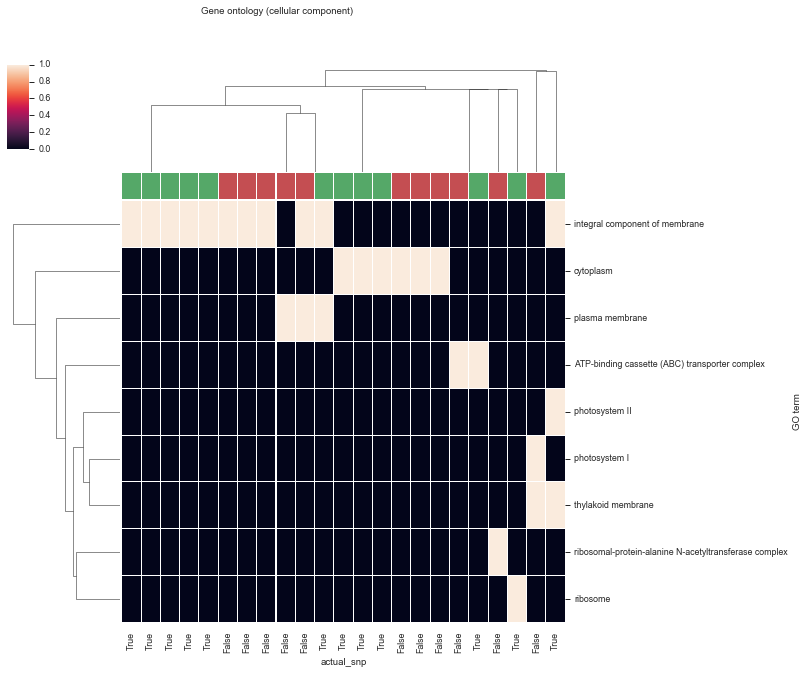

Gene ontology (biological process) (33, 26)


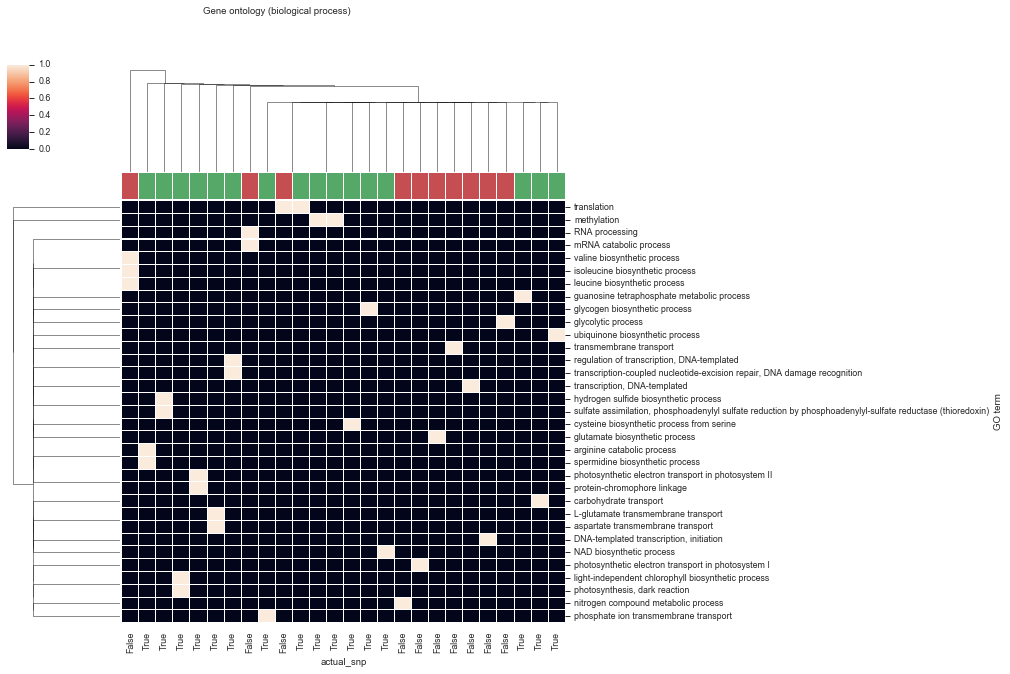

In [412]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >0], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

Gene ontology (molecular function) (61, 36)


<Figure size 432x288 with 0 Axes>

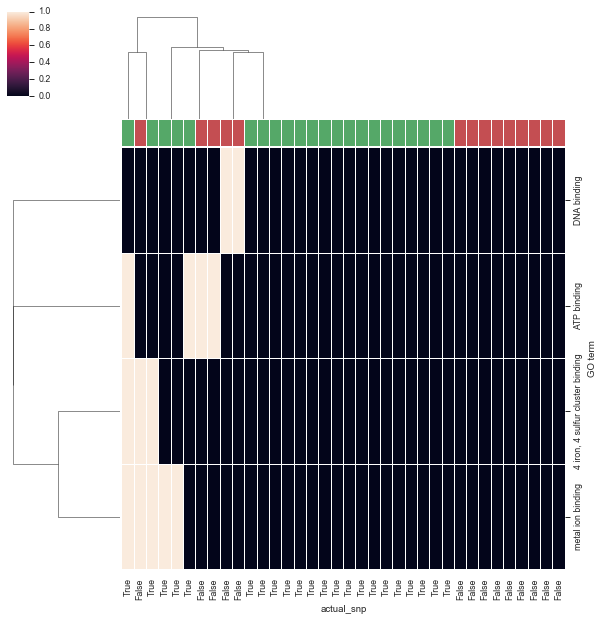

Gene ontology (cellular component) (9, 23)


<Figure size 432x288 with 0 Axes>

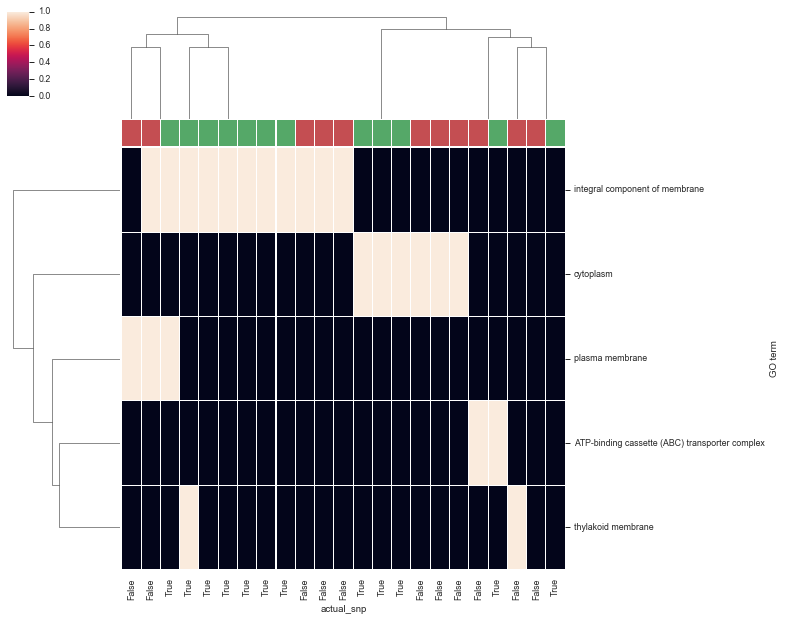

Gene ontology (biological process) (33, 26)


<Figure size 432x288 with 0 Axes>

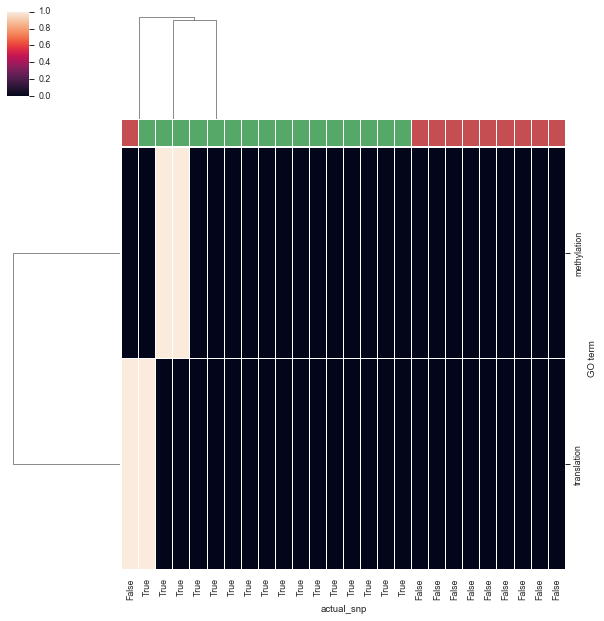

In [405]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >1], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

Gene ontology (molecular function) (278, 36)


<Figure size 432x288 with 0 Axes>

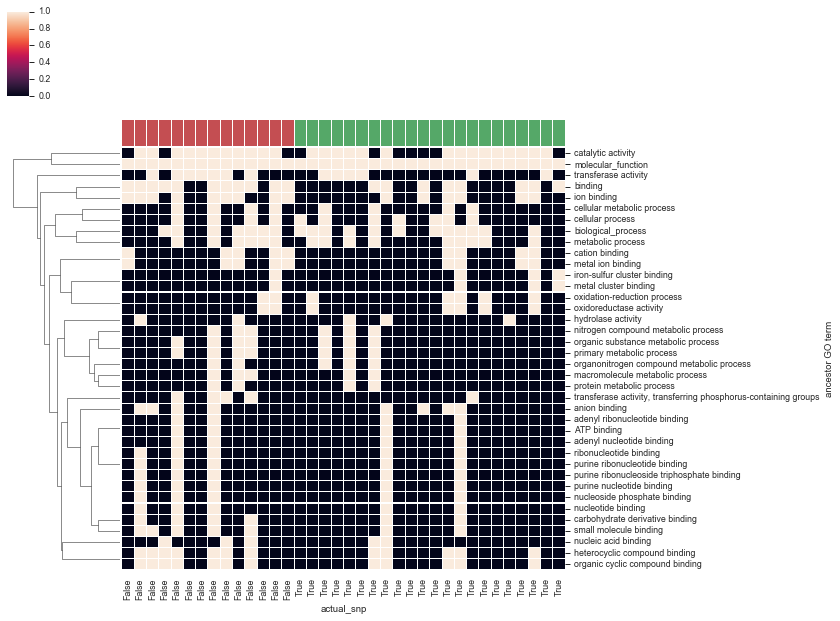

Gene ontology (cellular component) (32, 23)


<Figure size 432x288 with 0 Axes>

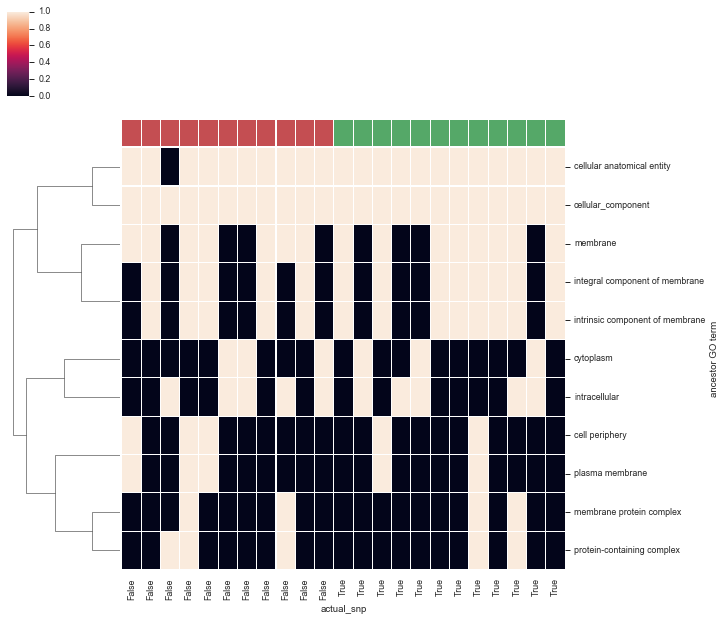

Gene ontology (biological process) (270, 26)


<Figure size 432x288 with 0 Axes>

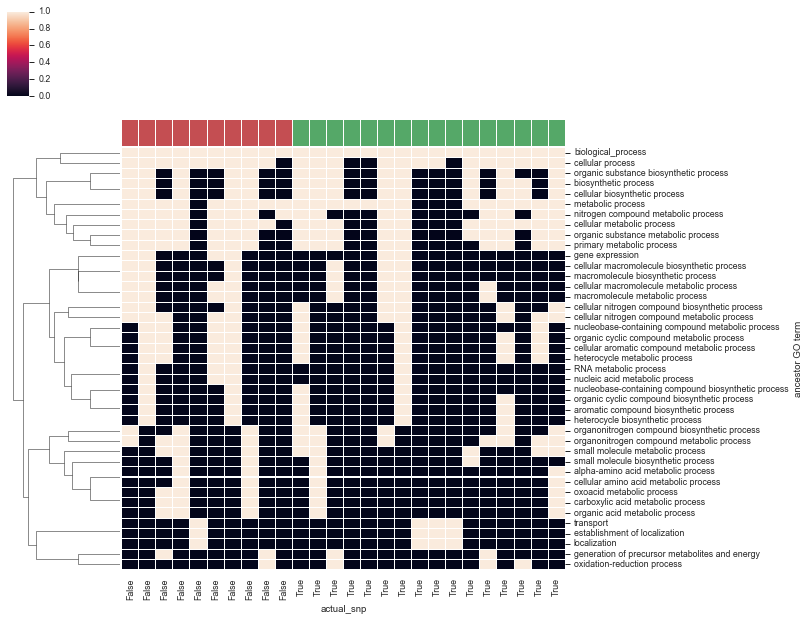

In [464]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                  col_colors=col_colors
                , col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

Gene ontology (molecular function) (165, 22)


<Figure size 432x288 with 0 Axes>

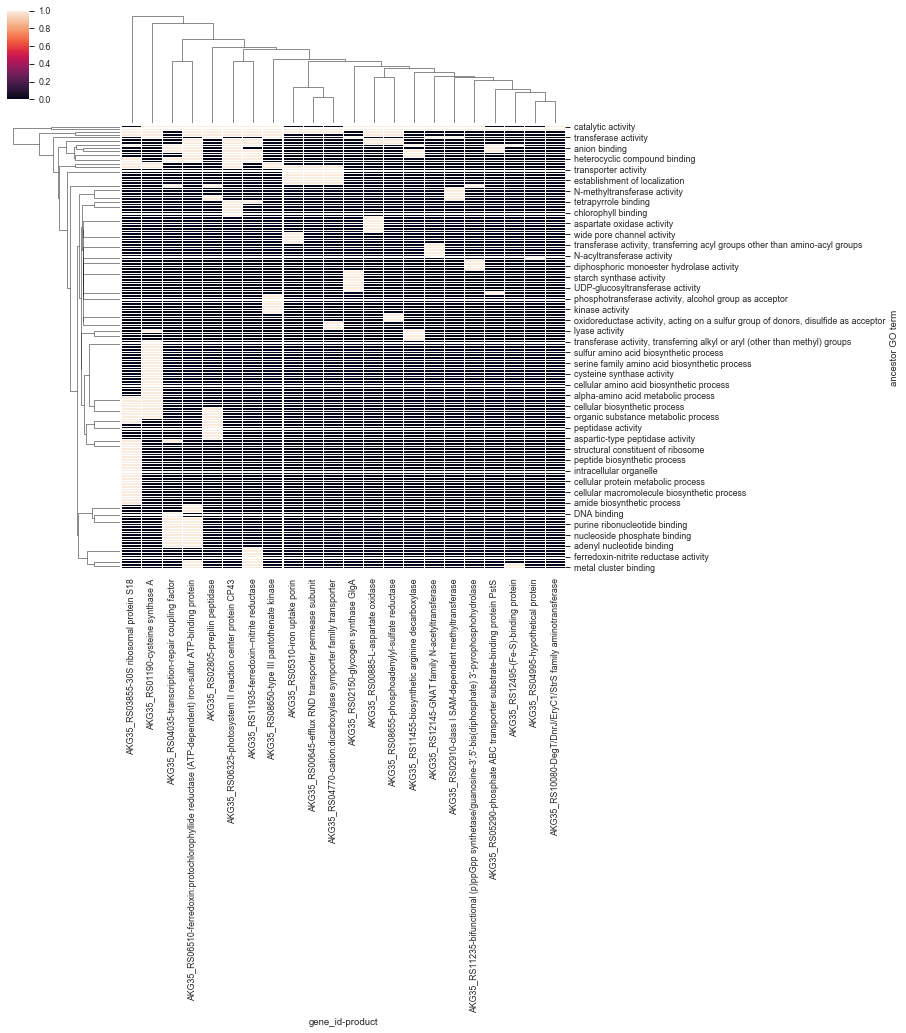

Gene ontology (cellular component) (26, 12)


<Figure size 432x288 with 0 Axes>

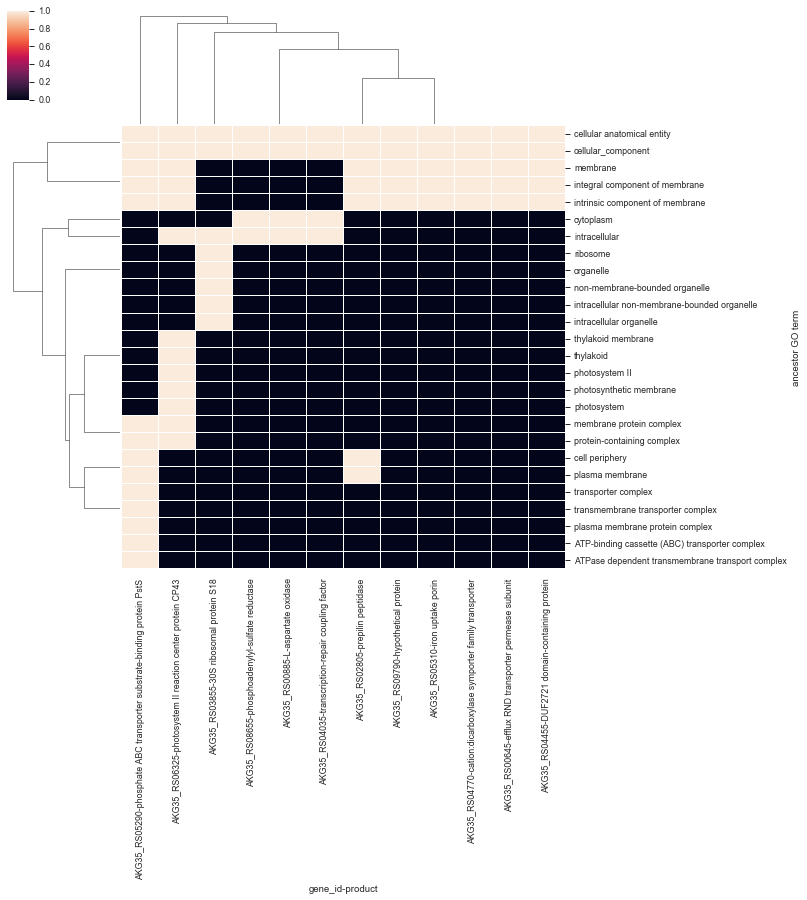

Gene ontology (biological process) (226, 16)


<Figure size 432x288 with 0 Axes>

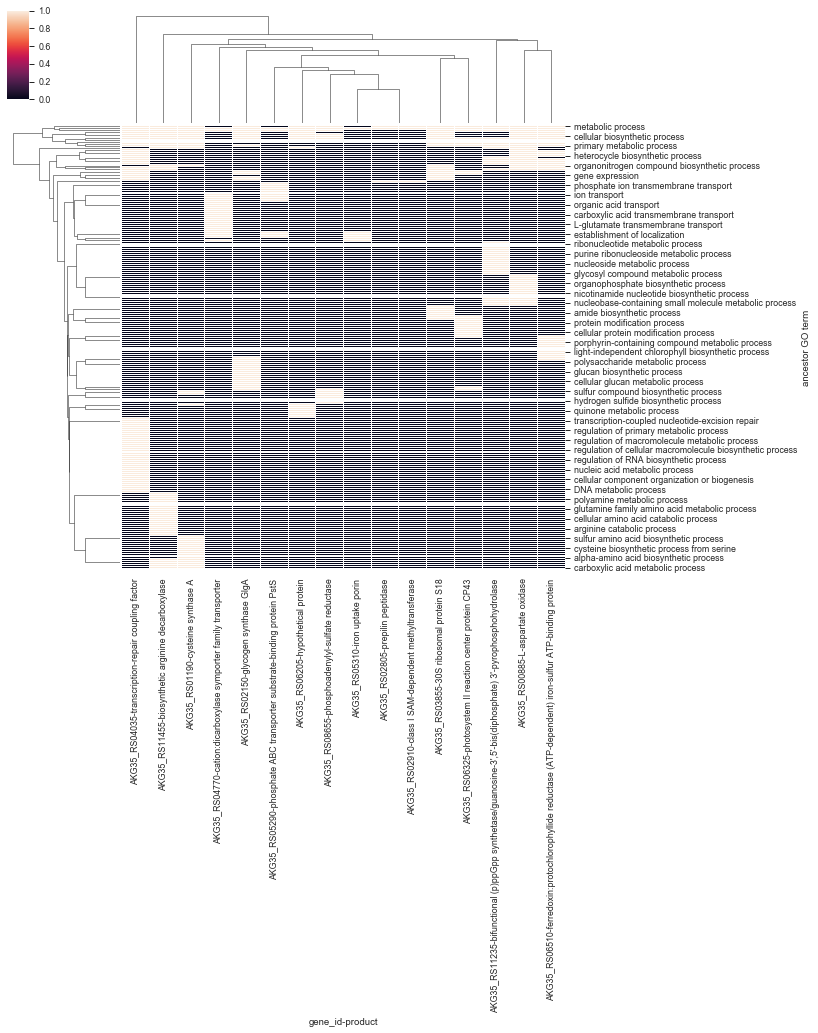

In [470]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i]) & go_df['actual_snp']
                    ].drop_duplicates(['gene_id', 'ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=[#'actual_snp',
                                                        'gene_id', 'product'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    #pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    #ut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    #ol_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                   #col_colors=col_colors
                #, col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [402]:
row_colors

Index(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
      dtype='object', name='actual_snp')

In [391]:
pvdf.sum(axis=1) >3

ancestor GO term
ADP metabolic process              False
ATP generation from ADP            False
ATP metabolic process              False
C4-dicarboxylate transport         False
DNA metabolic process              False
                                   ...  
transport                           True
ubiquinone biosynthetic process    False
ubiquinone metabolic process       False
valine biosynthetic process        False
valine metabolic process           False
Length: 270, dtype: bool

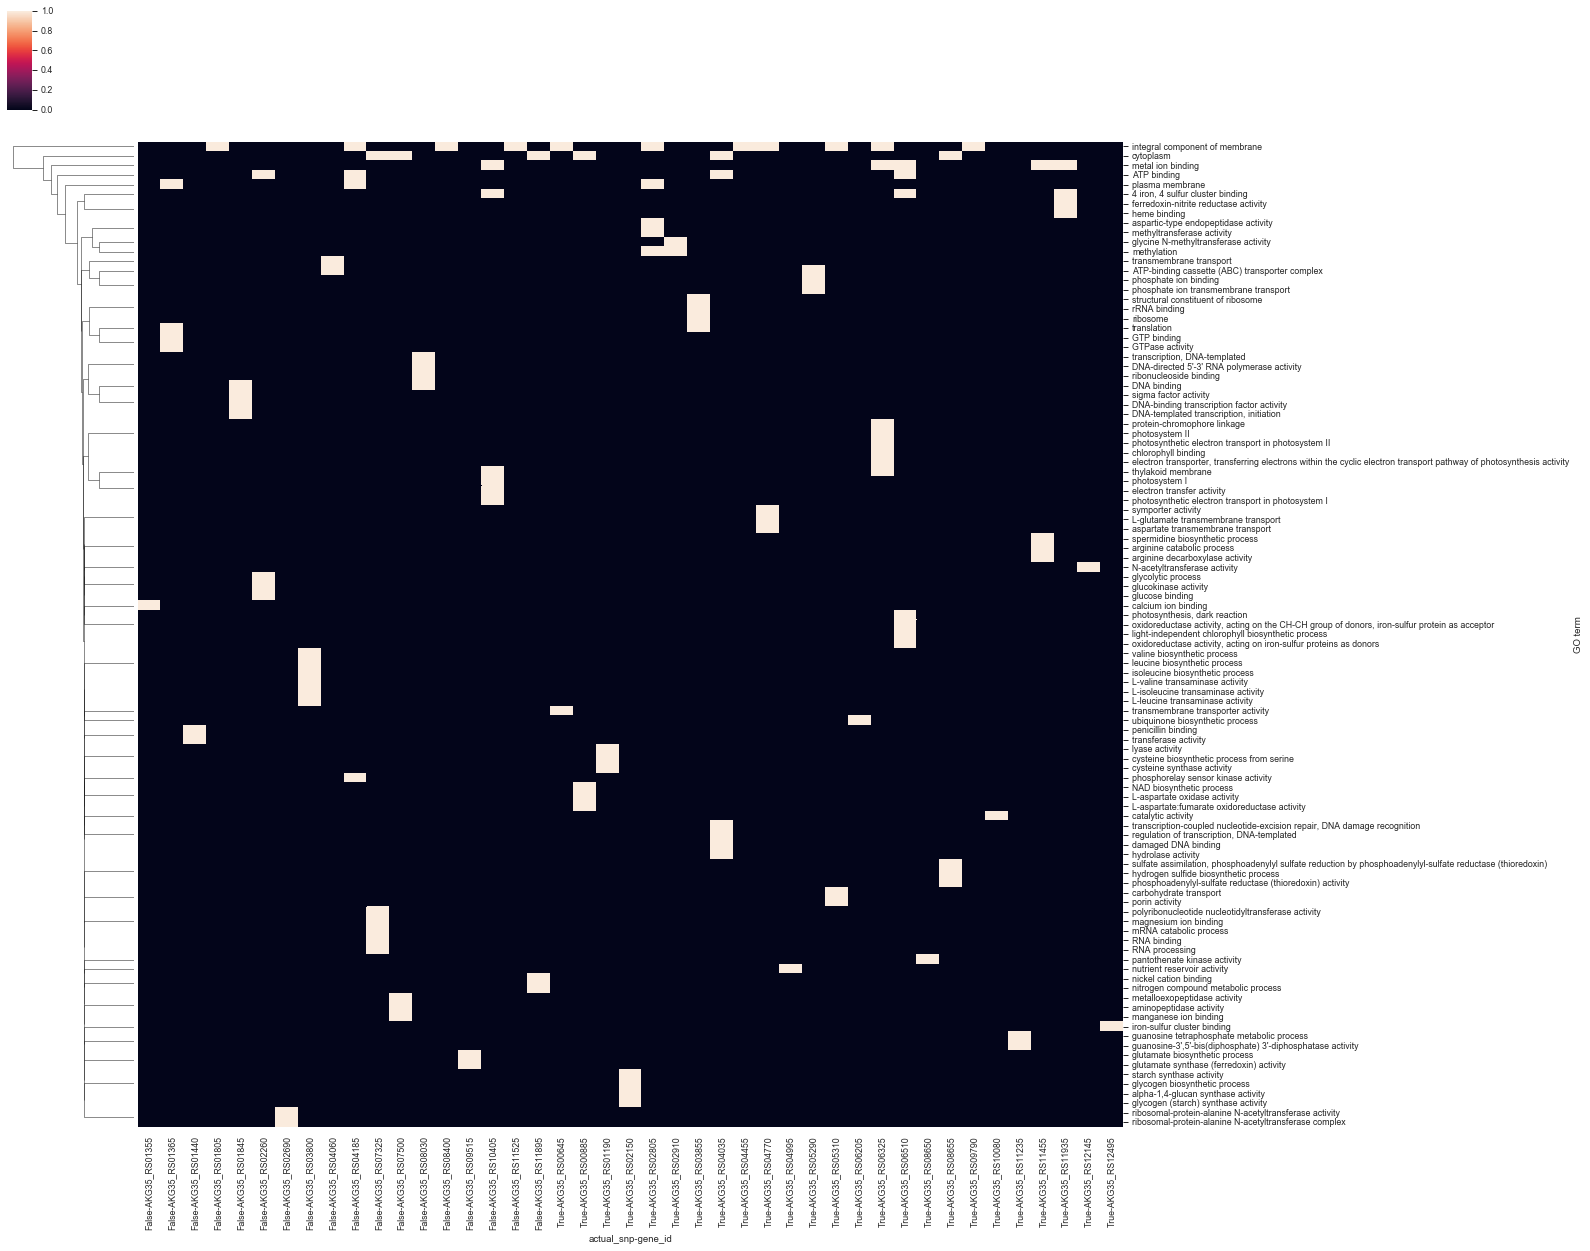

In [373]:
sns.set_context('paper')
sns.clustermap(data=pvdf, figsize=(20,20), col_cluster=False)

In [359]:
go_df.columns

Index([      'protein_id',          'gene_id',          'product',
                        0,                100,                100,
                      440,                440,       'actual_snp',
                   'From',               'To',            'Entry',
             'Entry name',    'Protein names',       'Gene names',
               'Organism',           'Length',        'GO aspect',
                'GO term',             'GOid',       'ancestorID',
       'ancestor GO term'],
      dtype='object')

In [364]:
pvdf.head()

actual_snp                                             False                \
gene_id                                        AKG35_RS01355 AKG35_RS01365   
GO term                                                                      
4 iron, 4 sulfur cluster binding                         nan           nan   
ATP binding                                              nan           nan   
ATP-binding cassette (ABC) transporter complex           nan           nan   
DNA binding                                              nan           nan   
DNA-binding transcription factor activity                nan           nan   

actual_snp                                                                  \
gene_id                                        AKG35_RS01440 AKG35_RS01805   
GO term                                                                      
4 iron, 4 sulfur cluster binding                         nan           nan   
ATP binding                                              nan           nan   
ATP-binding cassette (ABC) transporter complex           nan           nan   
DNA binding                                              nan           nan   
DNA-binding transcription factor activity                nan           nan   

actual_snp                                                                  \
gene_id                                        AKG35_RS01845 AKG35_RS02260   
GO term                                                                      
4 iron, 4 sulfur cluster binding                         nan           nan   
ATP binding                                              nan             1   
ATP-binding cassette (ABC) transporter complex           nan           nan   
DNA binding                                                1           nan   
DNA-binding transcription factor activity                  1           nan   

actual_snp                                                                  \
gene_id                                        AKG35_RS02690 AKG35_RS03800   
GO term                                                                      
4 iron, 4 sulfur cluster binding                         nan           nan   
ATP binding                                              nan           nan   
ATP-binding cassette (ABC) transporter complex           nan           nan   
DNA binding                                              nan           nan   
DNA-binding transcription factor activity                nan           nan   

actual_snp                                                                  \
gene_id                                        AKG35_RS04060 AKG35_RS04185   
GO term                                                                      
4 iron, 4 sulfur cluster binding                         nan           nan   
ATP binding                                              nan             1   
ATP-binding cassette (ABC) transporter complex             1           nan   
DNA binding                                              nan           nan   
DNA-binding transcription factor activity                nan           nan   

actual_snp                                      ...         True   \
gene_id                                         ... AKG35_RS06510   
GO term                                         ...                 
4 iron, 4 sulfur cluster binding                ...             1   
ATP binding                                     ...             1   
ATP-binding cassette (ABC) transporter complex  ...           nan   
DNA binding                                     ...           nan   
DNA-binding transcription factor activity       ...           nan   

actual_snp                                                                  \
gene_id                                        AKG35_RS08650 AKG35_RS08655   
GO term                                                                      
4 iron, 4 sulfur cluster binding                         nan           nan   
ATP bindin

# Unmapped BLAST

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv('contigs.fasta.nt.blastn', names=unmapped_header, sep='\t', comment='#')

In [ ]:
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.head()

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv(os.path.join('DNA', 'unmapped.axenic.nt.blastn'), names=unmapped_header, sep='\t', comment='#')
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
data_dpath = os.path.join('DNA','kraken_unmapped')
def _parse_csv(i):
    fpath = os.path.join(data_dpath, f'{160000+i}.bracken.species.txt')
    df =  pd.read_csv(fpath, sep='\t') 
    df['sample_number'] = i
    return df
tmpdf = [_parse_csv(i) for i in [4] + list(range(10,22))]
kraken_unmapped_gdf =pd.concat(tmpdf)
kraken_unmapped_gdf = pd.merge(kraken_unmapped_gdf, meta_df, on='sample_number', how='left')

In [ ]:
kraken_unmapped_gdf.sample_number.value_counts().sort_index()

In [ ]:
kraken_unmapped_gdf.columns

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='fraction_total_reads')
sns.heatmap(pkraken_unmapped_gdf*100, cmap='coolwarm', annot=True, vmax=30,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
plt.title('% unmapped reads', y=1)

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='new_est_reads')
sns.heatmap(pkraken_unmapped_gdf, cmap='coolwarm', annot=True, vmax=5000,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
            
plt.title('unmapped reads', y=1)

# spades stats

In [ ]:
spades_header = ['Node', 'Length', 'Coverage']
df_spades_all = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped_contigs.txt'), names=spades_header)
df_spades_axenic = pd.read_csv(os.path.join('DNA', 'dnaseq', 'axenic_unmapped_contigs.txt'), names=spades_header)


Any chance it could be a bacteriophage? 
I would recommend performing a de novo assembly both on all the data and also on the unmapped data. 
It would be interesting to look at how the data plot 
(we plot **summed assembly length vs average coverage when sorted from highest coverage to lowest**).


In [ ]:
df_spades_all.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_all['Summed Assembly Length'] = df_spades_all['Length'].cumsum()
df_spades_all['Average Coverage'] = df_spades_all['Coverage'].expanding().mean()

In [ ]:
df_spades_axenic.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_axenic['Summed Assembly Length'] = df_spades_axenic['Length'].cumsum()
df_spades_axenic['Average Coverage'] = df_spades_axenic['Coverage'].expanding().mean()

In [ ]:
df_spades_all.head()

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_all, x='Summed Assembly Length', y='Average Coverage',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,1e7)
plt.ylim(-1000,8000)
plt.title('Unmapped MIT0604 Reads ')

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_axenic, x='Summed Assembly Length', y='Average Coverage', color='green',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,0.4e7)
plt.ylim(-100,600)
plt.title('Unmapped Axenic MIT0604 Reads ')

In [ ]:
df_spades_all.head(20)

In [ ]:
df_spades_axenic.head(20)

In [ ]:
unmapped_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped-Alignment.xml')
unmapped_axenic_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped axenic-Alignment.xml')

from Bio.Blast import NCBIXML
def _unmapped_blastx_to_rec(blast_rec):
    query_id = blast_rec.query.split('.')[0] #.replace(' unnamed protein product','').replace('lcl|','')
    node_id = int(query_id.split('_')[1])
    results = [{
        'query' : query_id,
        'Node' : node_id,
        'Subject' : a.hit_def,
        'Accession' : d.accession,
        'Qcov': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'Ident': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results
fh = open(unmapped_blastx_fpath)
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
unblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()
fh = open(unmapped_axenic_blastx_fpath )
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
axblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()

In [ ]:
unblastx_df.head()

In [ ]:
unblastx_df = pd.merge(df_spades_all.loc[df_spades_all.Coverage > 50], 
         unblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')
axblastx_df = pd.merge(df_spades_axenic.loc[df_spades_axenic.Coverage > 20], 
         axblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')

In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(unblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(axblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
unblastx_df.columns